In [10]:
import fitz  # PyMuPDF for PDF text extraction
import requests
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter
from concurrent.futures import ThreadPoolExecutor  # For parallel processing
import streamlit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pdfplumber
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import faiss
import hashlib
import json
import os
import re
from sentence_transformers import SentenceTransformer
from docx import Document
%matplotlib inline

In [3]:
from scipy.stats import f_oneway, kruskal
from scipy.stats import ttest_ind
#from nltk.translate.meteor import meteor_score
from bert_score import score as bert_scorer
import torch
import csv
from bs4 import BeautifulSoup
import statistics
from collections import Counter
from bert_score import score
from bert_score import BERTScorer
import glob

## Testing the LLM Model

In [4]:
# URL where the Ollama API is running locally
url = "http://localhost:11434/api/generate"

In [5]:
# Define the model name (e.g., deepseek-7b)
#model_name = "deepseek-r1:8b"
model_name = "mistral"

In [6]:
# Define the prompt
prompt = "What is the capital of Pakistan?Please elaborate"

In [7]:
# Create the payload for the API request
payload = {
    "model": model_name,
    "prompt": prompt,
    "stream": False 
}


In [8]:
# Sending the request to the Ollama API
response = requests.post(url, json=payload)

In [12]:
# Checking if the request was successful
if response.status_code == 200:
    # Parse the response JSON
    response_json = response.json()
    # Extract the generated text
    generated_text = response_json.get("response", "No response generated.")
    print("Generated Text:", generated_text)
else:
    print("Error:", response.status_code, response.text)

Generated Text:  The capital of Pakistan is Islamabad. Islamabad was made the capital on August 14, 1947, and officially became functional on November 13, 1959. It is located in the north-central part of the country and serves as the political center of Pakistan, housing the national government and many embassies.

Islamabad was purpose-built as a capital; it was carefully planned to be a modern, well-organized city, with wide streets, large green areas, and impressive government buildings. It is surrounded by Margalla Hills, which provide a beautiful natural backdrop to the urban landscape. The city's design emphasizes its role as a symbol of Pakistan's new identity following independence from British colonial rule.

The capital city was designed by Turkish architect, Mimar Kemaleddin, with the collaboration of a team of architects led by Turkish-American architect, Albert Mayer. The plan for Islamabad was based on the concept of a garden city and reflects the traditional Muslim ideal

## Testing the PDF sumarization 

In [250]:
def extract_reference_section(structured_text: dict, doc: fitz.Document) -> dict:
    
    # Expanded section for reference
    REF_HEADERS = {
        'reference', 'references', 'bibliography', 'works cited',
        'literature cited', 'reference list', 'publications','R EFERENCES'
        'REFERENCE', 'REFERENCES', 'BIBLIOGRAPHY', 'WORKS CITED'
    }
    
    # Bibliographic entry patterns for regex
    BIBLIO_PATTERNS = [
        # Author-date styles
        r'^[A-Z][a-z]+,\s[A-Z]\.(?:\s[A-Z]\.)?\s\(\d{4}\)\.',  # Author, A. A. (2023).
        r'^[A-Z][a-z]+\s[A-Z][a-z]+,\s[A-Z]\.\s\(\d{4}\)\.',   # Author Name, A. (2023).
        
        # Numbered styles
        r'^\[\d+\]\s+[A-Z]',                                   # [1] Author...
        r'^\d+\.\s+[A-Z]',                                     # 1. Author...
        
        # Journal article patterns
        r'\bvol\.\s\d+,\spp?\.\s\d+-\d+',                      # vol. 12, p. 123-125
        r'\b\d+\(\d+\):\s\d+-\d+',                             # 12(3): 123-125
        
        # Book patterns
        r'\b[A-Z][a-z]+:\s[A-Z][a-z]+\s[Pp]ress',             # City: Publisher Press
        r'\b[A-Z][a-z]+\s[Pp]ress',                           # Publisher Press
        
        # Common bibliography elements
        r'\bdoi:\s?10\.\d+',                                   # doi: 10.xxxx
        r'\bhttps?://[^\s]+',                                  # URLs
        r'\bISBN\s[\d\-X]+',                                   # ISBN numbers
        r'\bRetrieved\sfrom'                                   # Retrieved from...
    ]
    
    
    ref_sections = {}
    for section, content in structured_text.items():
        section_lower = section.lower()
        
       
        if any(ref_header in section_lower for ref_header in REF_HEADERS):
            ref_sections[section] = content
            continue
            
        
        pattern_count = sum(len(re.findall(pattern, content)) for pattern in BIBLIO_PATTERNS)
        if pattern_count >= 3:
            ref_sections[section] = content
    

    for section, content in ref_sections.items():
        
        cleaned_content = re.sub(r'\s+', ' ', content)  
        
       
        split_success = False
        split_methods = [
            r'(?<=\])\s+(?=\[)',    # Between numbered refs [1] [2]
            r'\n\s*\d+\.\s+',       # Numbered list 1. 2.
            r'\n\s*[A-Z][a-z]+,',   # New line starting with Author Last,
            r'\n\s*[A-Z][a-z]+\s',  # New line starting with Author
            r'\n\s*•\s+',           # Bullet points
            r'\n\s*\*'              # Asterisk separators
        ]
        
        references = []
        for method in split_methods:
            if not references:  
                references = [r.strip() for r in re.split(method, cleaned_content) if r.strip()]
                split_success = len(references) > 3  
        
        # Format references consistently
        if split_success:
            formatted_refs = []
            for i, ref in enumerate(references, 1):
               
                ref = re.sub(r'^[\[\(]?\d+[\]\)]?\s*', '', ref)
                
                if ref and not ref[0].isupper():
                    ref = ref[0].upper() + ref[1:]
                formatted_refs.append(f"[{i}] {ref}")
            
            structured_text[section] = '\n'.join(formatted_refs)
    
    return structured_text

In [248]:
def extract_structured_text_from_pdf(pdf_path):
    
    

    # Error handling added while trying to open/parse PDF
    try:
        doc = fitz.open(pdf_path)
    except Exception as e:
        print(f"Error opening PDF: {e}")
        return "", {}
    
    
    structured_text = {}
    current_section = "Preamble"  
    structured_text[current_section] = ""
    
    # Extracting metadata if available or encoded in pdf
    try:
        metadata = doc.metadata
        if metadata:
            # Extract title from metadata if available
            if metadata.get('title') and len(metadata.get('title').strip()) > 3:
                structured_text["Title"] = metadata.get('title').strip()
            
            # Extract author from metadata if available
            if metadata.get('author') and len(metadata.get('author').strip()) > 3:
                structured_text["Authors"] = metadata.get('author').strip()
    except Exception as e:
        print(f"Error extracting metadata: {e}")
    
    # Using first page text to extract title information and Authors
    first_page = doc[0]
    first_page_text = first_page.get_text("text")
    first_few_lines = first_page_text.split('\n')[:20]  
    
    # Extracting title if not already found in metadata
    if "Title" not in structured_text:
        
        for line in first_few_lines:
            if line.strip() and len(line.strip()) > 3:
                
                if any(word in line.lower() for word in ['journal', 'conference', 'proceedings', 'volume']):
                    continue
                
                
                blocks = first_page.get_text("dict")["blocks"]
                for block in blocks:
                    if "lines" not in block:
                        continue
                    
                    for block_line in block["lines"]:
                        line_text = " ".join([span["text"] for span in block_line["spans"]])
                        if line_text.strip() == line.strip():
                            # Check if spans have larger font or bold formatting
                            for span in block_line["spans"]:
                                if span["size"] > 12 or "bold" in span.get("font", "").lower():
                                    structured_text["Title"] = line.strip()
                                    break
                        if "Title" in structured_text:
                            break
                    if "Title" in structured_text:
                        break
                
                
                if "Title" not in structured_text:
                    structured_text["Title"] = line.strip()
                break
    
    # More author extraction code if not already found in metadata
    if "Authors" not in structured_text:
        author_candidates = []
        author_section_found = False
        
        
        author_patterns = [
            r'(?:^|\s)(?:by|authors?[:]\s+)([\w\s,.()-]+)',  # "by" or "authors:" prefix
            r'(?:^|\s)((?:[A-Z][a-z]+\s+[A-Z][a-z]+(?:,|and|\s|&|$))+)',  # Names like "John Smith, Jane Doe"
            r'(?:^|\s)([A-Z][a-z]+(?:\s+[A-Z][a-z]+)+(?:\s*,\s*[A-Z][a-z]+(?:\s+[A-Z][a-z]+)+)+)',  # Multiple names separated by commas
            r'(?:^|\s)([A-Z][a-z]+(?:\s+[A-Z][a-z]+)+(?:\s*and\s*[A-Z][a-z]+(?:\s+[A-Z][a-z]+)+))'  # Names connected by "and"
        ]
        
        # Looking for lines potentially containing author names
        for i, line in enumerate(first_few_lines[1:10], 1): 
            line = line.strip()
            if not line:
                continue
                
            
            if any(word.lower() in line.lower() for word in ['abstract', 'introduction', 'copyright', 'published']):
                continue
                
            # Checking for email addresses which often accompany author names
            email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
            has_email = bool(re.search(email_pattern, line))
            
            # Checking for any academic affiliations
            affiliation_terms = ['university', 'college', 'institute', 'department', 'laboratory', 'school', 'center']
            has_affiliation = any(term in line.lower() for term in affiliation_terms)
            
            # Check for any academic titles
            academic_titles = ['dr', 'prof', 'professor', 'phd']
            has_title = any(f" {title}" in f" {line.lower()} " for title in academic_titles)
            
            # Applying the author patterns to detect author names
            is_likely_author_line = False
            for pattern in author_patterns:
                if re.search(pattern, line):
                    is_likely_author_line = True
                    break
            
            # Scoring on the probability of text being an author name
            author_score = 0
            if ',' in line or ' and ' in line.lower():
                author_score += 3
            if has_email:
                author_score += 4
            if has_affiliation:
                author_score += 2
            if has_title:
                author_score += 3
            if is_likely_author_line:
                author_score += 5
            
            
            if re.search(r'[A-Za-z]\d+', line) or re.search(r'[A-Za-z]\*', line):
                author_score += 3
            
         
            if author_score >= 3 or is_likely_author_line:
                
                cleaned_line = re.sub(email_pattern, '', line)
                cleaned_line = re.sub(r'\s+', ' ', cleaned_line).strip()
                author_candidates.append(cleaned_line)
                author_section_found = True
            elif author_section_found:
                
                break
        
        if author_candidates:
            structured_text["Authors"] = ', '.join(author_candidates)
    
 
    font_sizes = []
    font_styles = []
    for page in doc:
        blocks = page.get_text("dict")["blocks"]
        for block in blocks:
            if "lines" not in block:
                continue
            for line in block["lines"]:
                for span in line["spans"]:
                    if "size" in span:
                        font_sizes.append(span["size"])
                    if "font" in span:
                        font_styles.append(span["font"].lower())

    
    median_font_size = statistics.median(font_sizes) if font_sizes else 11
    most_common_font = Counter(font_styles).most_common(1)[0][0] if font_styles else ""
    
    # Section numbering patterns - comprehensive coverage for academic papers
    section_number_patterns = [
        
        r'^\d+\.\s+',                    # "1. "
        r'^\d+\.\d+\.\s+',               # "1.1. "
        r'^\d+\.\d+\.\d+\.\s+',          # "1.1.1. "
        r'^[A-Z]\.\s+',                  # "A. "
        r'^[a-z]\)\s+',                  # "a) "
        r'^\([a-z]\)\s+',                # "(a) "
        r'^[IVXLCDM]+\.\s+',             # "IV. " (Roman numerals)
        r'^\d+\s+',                      # "1 " (just a number and space)
        r'^\d+\)',                       # "1)"
        r'^\d+\-\d+',                    # "1-1"
        r'^Section\s+\d+',               # "Section 1"
    ]
    
    
    section_number_regex = '|'.join(section_number_patterns)
    
    # Common section names in research papers for search criteria
    common_sections = [
        "abstract", "introduction", "related work", "previous work", "background",
        "methodology", "methods", "experimental setup", "experiment", "experiments",
        "evaluation", "results", "discussion", "conclusion", "conclusions",
        "future work", "references", "appendix", "acknowledgments", "acknowledgements",
        "literature review", "materials and methods", "data", "implementation", 
        "system design", "procedure", "research design", "limitations", "contributions"
    ]
    
    
    header_footer_candidates = []
    
    
    for page_idx in range(min(5, len(doc))):  
        page = doc[page_idx]
        page_dict = page.get_text("dict")
        
        
        top_text = ""
        bottom_text = ""
        
        if "blocks" in page_dict:
            
            blocks = sorted(page_dict["blocks"], key=lambda b: b["bbox"][1] if "bbox" in b else 0)
            
            
            if blocks:
                top_block = blocks[0]
                bottom_block = blocks[-1]
                
                if "lines" in top_block and top_block["lines"]:
                    line_spans = top_block["lines"][0]["spans"] if top_block["lines"][0]["spans"] else []
                    top_text = " ".join([span["text"] for span in line_spans])
                    
                if "lines" in bottom_block and bottom_block["lines"]:
                    line_spans = bottom_block["lines"][-1]["spans"] if bottom_block["lines"][-1]["spans"] else []
                    bottom_text = " ".join([span["text"] for span in line_spans])
        
        if top_text:
            header_footer_candidates.append(("top", top_text))
        if bottom_text:
            header_footer_candidates.append(("bottom", bottom_text))
    
    
    headers_footers = []
    candidate_counts = Counter([text for _, text in header_footer_candidates])
    for text, count in candidate_counts.items():
        if count >= 2 and len(text.strip()) > 0:  # If it appears on multiple pages, likely a header/footer
            headers_footers.append(text)
    
    
    def is_header_footer(text):
        return any(hf in text for hf in headers_footers)
    
   
    def get_previous_line(block, line):
        if "lines" in block:
            try:
                line_idx = block["lines"].index(line)
                if line_idx > 0:
                    return block["lines"][line_idx - 1]
            except ValueError:
                pass
        return None
    
    def get_next_line(block, line):
        if "lines" in block:
            try:
                line_idx = block["lines"].index(line)
                if line_idx < len(block["lines"]) - 1:
                    return block["lines"][line_idx + 1]
            except ValueError:
                pass
        return None
    
    def line_is_empty(line):
        if not line or "spans" not in line:
            return True
        return all(not span.get("text", "").strip() for span in line["spans"])
    
    # Processing each page for section extraction
    previous_spans = []  
    figures_tables = []  
    previous_line_empty = True 
    
    for page_num, page in enumerate(doc):
        
        blocks = page.get_text("dict")["blocks"]
        
        
        blocks = sorted(blocks, key=lambda b: b["bbox"][1] if "bbox" in b else 0)
        
        for block_idx, block in enumerate(blocks):
            if "lines" not in block:
                continue
            
            for line_idx, line in enumerate(block["lines"]):
                line_spans = []
                line_text = ""
                
                for span in line["spans"]:
                    text = span["text"].strip()
                    if not text:
                        continue
                    
                    line_spans.append(span)
                    line_text += text + " "
                
                line_text = line_text.strip()
                if not line_text:
                    previous_line_empty = True
                    continue
                
                
                if is_header_footer(line_text):
                    continue
                
                # Checking for figure or table captions
                figure_match = re.search(r'(fig(?:ure)?\.?\s+\d+|table\.?\s+\d+)[\.\:](.*)', line_text, re.IGNORECASE)
                if figure_match:
                    figure_type = "Table" if "table" in figure_match.group(1).lower() else "Figure"
                    caption_text = figure_match.group(2).strip()
                    figures_tables.append((figure_type, caption_text))
                    continue
                
                # Checking if this is a section header based on multiple criteria
                is_header = False
                section_name = line_text
                
                # Checking for section numbering pattern
                has_section_number = bool(re.match(section_number_regex, line_text))
                
                
                clean_text = re.sub(section_number_regex, '', line_text).lower().strip()
                
                # Checking if the text contains a common section name
                contains_common_section = any(section in clean_text for section in common_sections)
                
                # Checking for formatting propert that suggest that the text is a header
                is_bold = any("bold" in span.get("font", "").lower() for span in line_spans)
                is_larger_font = any(span["size"] > (median_font_size * 1.2) for span in line_spans if "size" in span)
                is_all_caps = line_text.isupper() and len(line_text) > 3
                
                # Getting contextual information
                is_paragraph_start = False
                if line_idx == 0 or previous_line_empty:
                    is_paragraph_start = True
                
                previous_line = get_previous_line(block, line)
                next_line = get_next_line(block, line)
                previous_line_empty = line_is_empty(previous_line)
                next_line_empty = line_is_empty(next_line)
                
                                
                last_line_ends_with_sentence = False
                if previous_spans:
                    last_text = previous_spans[-1]["text"].strip()
                    
                    if last_text and (last_text.endswith('.') or last_text.endswith('?') or last_text.endswith('!')):
                        last_line_ends_with_sentence = True
                
                header_score = 0
                
                if has_section_number:
                    header_score += 6  
                if contains_common_section:
                    header_score += 5 
                
                # Require BOTH bold AND larger font for a strong signal
                if is_bold and is_larger_font:
                    header_score += 5  
                elif is_bold:  
                    header_score += 2  
                elif is_larger_font:  
                    header_score += 2
                
                # Only short all-caps text gets a boost
                if is_all_caps and len(line_text) < 30:
                    header_score += 1  
                
                # Penalize long text that's unlikely to be a header
                if len(line_text) > 30:
                    header_score -= 3 
                
                # Context analysis - boost score if appears to be at paragraph start
                if is_paragraph_start:
                    header_score += 1
                
                # Penalize if text appears to be within a paragraph
                if (previous_line and not previous_line_empty and 
                    next_line and not next_line_empty and 
                    not has_section_number and not is_all_caps):
                    header_score -= 3  

                # Then in the header scoring:
                if last_line_ends_with_sentence or previous_line_empty:
                    header_score += 3  
                else:
                    header_score -= 4  
                
                # Threshold score for considering a line as a header 
                is_header = header_score >= 10 
                
                if is_header:
                    # Cleaning section name (remove excess whitespace, numbering)
                    section_name = re.sub(section_number_regex, '', line_text)
                    section_name = section_name.strip()
                    
                    # If section name is too short, try to combine with next line
                    if len(section_name) <= 3:
                        # Look ahead to next line
                        next_line_text = ""
                        if next_line and "spans" in next_line:
                            next_line_text = " ".join([s["text"] for s in next_line["spans"] if "text" in s])
                        
                        if next_line_text and not re.match(section_number_regex, next_line_text):
                            section_name = f"{section_name} {next_line_text}".strip()
                    
                    # Checking if section name is valid
                    if len(section_name) > 1:
                        if section_name.lower() in [s.lower() for s in structured_text.keys()]:
                            
                            section_name = f"{section_name} (continued)"
                        
                        current_section = section_name
                        structured_text[current_section] = ""
                else:
                    # Appendding text to current section 
                    if not re.match(r'^\d+$', line_text) and len(line_text) > 1:
                        structured_text[current_section] += line_text + " "
                
                previous_spans = line_spans
                previous_line_empty = False
    
    # Special handling for the Abstract section
    if not any(s.lower() == "abstract" for s in structured_text.keys()):
        
        abstract_patterns = [
            r'Abstract[:\s—-]+([^\.]+(?:\.[^\.]+){0,10})',  
            r'ABSTRACT[:\s—-]+([^\.]+(?:\.[^\.]+){0,10})',  
            r'Abstract\s*\n+\s*([^\.]+(?:\.[^\.]+){0,10})' 
        ]
        
        for pattern in abstract_patterns:
            abstract_match = re.search(pattern, first_page_text, re.IGNORECASE | re.DOTALL)
            if abstract_match:
                structured_text["Abstract"] = abstract_match.group(1).strip()
                break
    
    # Special handling for references
    for key in list(structured_text.keys()):
        if "reference" in key.lower():
            ref_text = structured_text[key]
            
            ref_patterns = [
                r'(?:\[\d+\]|\[\w+\d+\]|\d+\.|\(\d+\))\s+[^[\d\(]+',  # Standard numbered references
                r'(?:[A-Z][a-z]+(?:,|\s+and|\s+et al\.)\s+\d{4})[^,\d]+'  # Author year format
            ]
            
            for pattern in ref_patterns:
                ref_matches = re.findall(pattern, ref_text)
                if ref_matches:
                    structured_text[key] = '\n'.join([r.strip() for r in ref_matches if r.strip()])
                    break
    
    # Adding figures and tables to the structured text
    if figures_tables:
        structured_text["Figures and Tables"] = '\n'.join([f"{ft_type}: {caption}" for ft_type, caption in figures_tables])
    
    # Formatting the structured text as a well-formatted plain text
    formatted_text = ""
    for section, content in structured_text.items():
        if section == "Preamble" and not content.strip():
            continue  # Skip empty preamble
        formatted_text += f"== {section} ==\n{content.strip()}\n\n"
        
    structured_text = extract_reference_section(structured_text, doc)
    
    # Validating the output to check if we atleast detected the key sections we'd expect in academic papers
    expected_sections = ["Abstract", "Introduction", "Conclusion"]
    missing_sections = [s for s in expected_sections if not any(es.lower() in s.lower() for es in structured_text.keys() for s in expected_sections)]
    
    if missing_sections:
        print(f"Warning: Could not find these expected sections: {', '.join(missing_sections)}")
    
    return formatted_text, structured_text

In [496]:
a,b=extract_structured_text_from_pdf("Downloads/Research Papers 2/paper14.pdf")

In [498]:
print(len(b))
print(a)


39
== Preamble ==
Retrieval-Augmented Generation for Large Language Models: A Survey Yunfan Gao a , Yun Xiong b , Xinyu Gao b , Kangxiang Jia b , Jinliu Pan b , Yuxi Bi c , Yi Dai a , Jiawei Sun a , Meng Wang c , and Haofen Wang a,c a Shanghai Research Institute for Intelligent Autonomous Systems, Tongji University b Shanghai Key Laboratory of Data Science, School of Computer Science, Fudan University c College of Design and Innovation, Tongji University arXiv:2312.10997v5  [cs.CL]  27 Mar 2024 of large models exhibits several distinct stage characteristics. Initially, RAG’s inception coincided with the rise of the Transformer architecture, focusing on enhancing language models by incorporating additional knowledge through Pre- Training Models (PTM). This early stage was characterized by foundational work aimed at refining pre-training techniques [3]–[5].The subsequent arrival of ChatGPT [6] marked a pivotal moment, with LLM demonstrating powerful in context learning (ICL) capabilities

In [252]:
def summarize_text(text, model="deepseek-r1:8b"):
    
    url = "http://localhost:11434/api/generate"
    
    #prompt = f"Summarize the following research paper by frst giving a detailed Breakdown of abstract in simple words,and then for rest of the paper cited, give references for previous work done, How work done in this paper improves upon the work in existing literature,a cincise summary of methodology used and results:\n{text[:4000]}\n\nSummary:"  # Limit to 4000 chars
    #prompt = f"Summarize the following research Paper:\n{text}\n\nSummary:"  # Limit to 4000 chars
    #prompt = f"Who are the authors of this paper, just write names:\n{text}\n"  # Limit to 4000 chars
    # Updated prompt to work with structured text
    prompt = f"""
    Analyze the following research paper with its structured sections:

{text}

    Please provide:
    1. A detailed breakdown of the abstract in simple terms
    2. Provide the key references used in the paper along with their links and how does it relate to the problem statement or solution 
    3. Any exiting solutions if yes what makes this project standout and how this work improves upon existing literature
    4. A concise summary of methodology or techniques used in brief. 
    5. Main results and conclusions and proposed future work 
    """
    payload = {
        "model": model,
        "prompt": prompt,
        "stream": False
    }

    start_time = time.time()  # Start timer
    
    response = requests.post(url, json=payload)
    
    end_time = time.time()  # End timer
    elapsed_time = end_time - start_time  # Calculate time taken
    
    if response.status_code == 200:
        response_json = response.json()
        summary = response_json.get("response", "No response generated.")
    else:
        summary = f"Error: {response.status_code}, {response.text}"
    
    return summary, elapsed_time


In [253]:
if __name__ == "__main__":
    pdf_file_path = "Downloads/Data Mining_Final Report.pdf"
    print("Extracting structured text from PDF...")
    formatted_text, structured_data = extract_structured_text_from_pdf(pdf_file_path)
    
    # Save structured data to a file for inspection
    with open("structured_paper.txt", "w") as f:
        f.write(formatted_text)
    
    print(f"Structured text saved to structured_paper.txt")
    
    print("Generating summary...")
    summary, time_taken = summarize_text(formatted_text,model="mistral")
    
    print("\n--- Summary of the Research Paper ---\n")
    print(summary)
    print(f"\nTime taken for summarization: {time_taken:.2f} seconds")

Extracting structured text from PDF...
Structured text saved to structured_paper.txt
Generating summary...

--- Summary of the Research Paper ---

1. Detailed Breakdown of the Abstract:
   The abstract presents a system designed to detect fraudulent job postings, using machine learning algorithms. The design is user-friendly and interactive, allowing users to input job details and determine if a website is fraudulent. The core objective is to provide an easy-to-use interface for identifying potential scams. The project primarily focuses on the use of XGBoost and Random Forest algorithms, with comparisons made against other models like Logistic Regression and Decision Trees.

  2. Key References:
   - [1] Schonlau, M., & Zou, R. Y. (2020). The Random Forest Algorithm for The Stata Journal, vol. 20, no. 1, March 2020. [Link: https://www.tandfonline.com/doi/abs/10.1080/15368676.2020.1731954]
   - [11] Szeghalmy, S., & Fazekas, A. (February 2023). A Comparative Study of the Use of Stratifi

## Summarizing multiple papers in loop and saving to a json and csv file

In [500]:
def extract_paper_number(filename):
    match = re.search(r'paper(\d+)\.pdf', filename)
    return int(match.group(1)) if match else float('inf')

In [ ]:
if __name__ == "__main__":
    folder_path = "Downloads/Research Papers 2"  # Folder containing PDF files
    model_name = "mistral"
    summary_data = [] # Initialize a list to store summary results

    pdf_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith(".pdf") and f.lower().startswith("paper")],
        key=extract_paper_number
    )

    total_files = len(pdf_files)
    print(f"\n📄 Found {total_files} PDF files to process...\n")

    for idx, filename in enumerate(pdf_files, start=1):
        pdf_path = os.path.join(folder_path, filename)
        print(f"📘 [{idx}/{total_files}] Processing: {filename}")

        # Step 1: Extract structured text from the PDF
        print("   🔍 Extracting structured text...")
        formatted_text, structured_data = extract_structured_text_from_pdf(pdf_path)

        # Step 2: Collect basic metadata from the PDF
        print("   📊 Gathering metadata...")
        file_size_kb = round(os.path.getsize(pdf_path) / 1024, 2)  # in KB
        num_pages = len(fitz.open(pdf_path))
        word_count_original = len(formatted_text.split())

        # Step 3: Summarize the extracted text using the specified model
        print(f"   🤖 Summarizing with model '{model_name}'...")
        summary_text, time_taken = summarize_text(formatted_text, model=model_name)
        word_count_summary = len(summary_text.split())

        # Step 4: Organize all collected and generated information
        print("   📦 Storing results...")
        paper_summary = {
            "filename": filename,
            "pdf_size_kb": file_size_kb,
            "num_pages": num_pages,
            "original_word_count": word_count_original,
            "summary": summary_text,
            f"summary_word_count_{model_name}": word_count_summary,
            "model_used": model_name,
            "summarization_time_sec": round(time_taken, 2)
        }

        # Add the summary information to the master list
        summary_data.append(paper_summary)
        print("   ✅ Done.\n")

    # Step 5: Save all summaries and metadata into a JSON file
    output_path = "summarized_papers.json"
    print(f"💾 Writing summaries to {output_path}...")
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(summary_data, f, indent=4)

    print(f"\n✅ All {total_files} papers processed successfully! Summaries saved to '{output_path}'.")


In [494]:


 

if __name__ == "__main__":
    folder_path = "Downloads/Research Papers 2"  # Folder containing PDF files

    # List all models you want to run
    model_names = ["mistral", "llama3.2", "llama3.1", "gemma3", "deepseek-r1(8b)","qwen2.5"]

    # Gather and sort your PDF files once
    pdf_files = sorted(
        [f for f in os.listdir(folder_path)
         if f.endswith(".pdf") and f.lower().startswith("paper")],
        key=extract_paper_number
    )
    total_files = len(pdf_files)
    print(f"\n📄 Found {total_files} PDF files to process...\n")

    for model_name in model_names:
        summary_data = []

        print(f"=== Running summarization with model '{model_name}' ===\n")

        for idx, filename in enumerate(pdf_files, start=1):
            pdf_path = os.path.join(folder_path, filename)
            print(f"📘 [{idx}/{total_files}] {filename}")

            # Step 1: Extract structured text
            formatted_text, structured_data = extract_structured_text_from_pdf(pdf_path)

            # Step 2: Gather PDF metadata
            file_size_kb    = round(os.path.getsize(pdf_path) / 1024, 2)
            num_pages       = len(fitz.open(pdf_path))
            original_wc     = len(formatted_text.split())

            # Step 3: Summarize
            summary_text, time_taken = summarize_text(formatted_text, model=model_name)
            summary_wc = len(summary_text.split())

            # Step 4: Store
            summary_data.append({
                "filename":                   filename,
                "pdf_size_kb":                file_size_kb,
                "num_pages":                  num_pages,
                "original_word_count":        original_wc,
                f"summary_word_count_{model_name}": summary_wc,
                "model_used":                 model_name,
                "summarization_time_sec":     round(time_taken, 2),
                "summary_text":               summary_text
            })

            print("   ✅ Done.\n")

        # Convert to DataFrame and write CSV
        df = pd.DataFrame(summary_data)
        output_csv = f"summarized_papers_{model_name}.csv"
        df.to_csv(output_csv, index=False, encoding="utf-8-sig")
        print(f"💾 Saved results for '{model_name}' to {output_csv}\n")

    print("🎉 All models processed!")  



📄 Found 15 PDF files to process...

=== Running summarization with model 'mistral' ===

📘 [1/15] paper1.pdf
   ✅ Done.

📘 [2/15] paper2.pdf
   ✅ Done.

📘 [3/15] paper3.pdf
   ✅ Done.

📘 [4/15] paper4.pdf
   ✅ Done.

📘 [5/15] paper5.pdf
   ✅ Done.

📘 [6/15] paper6.pdf
   ✅ Done.

📘 [7/15] paper7.pdf
   ✅ Done.

📘 [8/15] paper8.pdf
   ✅ Done.

📘 [9/15] paper9.pdf
   ✅ Done.

📘 [10/15] paper10.pdf
   ✅ Done.

📘 [11/15] paper11.pdf
   ✅ Done.

📘 [12/15] paper12.pdf
   ✅ Done.

📘 [13/15] paper13.pdf
   ✅ Done.

📘 [14/15] paper14.pdf
   ✅ Done.

📘 [15/15] paper15.pdf
   ✅ Done.

💾 Saved results for 'mistral' to summarized_papers_mistral.csv

=== Running summarization with model 'llama3.2' ===

📘 [1/15] paper1.pdf
   ✅ Done.

📘 [2/15] paper2.pdf
   ✅ Done.

📘 [3/15] paper3.pdf
   ✅ Done.

📘 [4/15] paper4.pdf
   ✅ Done.

📘 [5/15] paper5.pdf
   ✅ Done.

📘 [6/15] paper6.pdf
   ✅ Done.

📘 [7/15] paper7.pdf
   ✅ Done.

📘 [8/15] paper8.pdf
   ✅ Done.

📘 [9/15] paper9.pdf
   ✅ Done.

📘 [10/15] pape

KeyboardInterrupt: 

In [17]:


# Load JSON file
with open("summarized_papers.json", "r", encoding="utf-8") as f:
    summaries = json.load(f)

# Print summaries for all papers
for paper in summaries:
    print(f"📄 {paper['filename']}")
    print(f"   📚 Pages: {paper['num_pages']} | Size: {paper['pdf_size_kb']} KB")
    print(f"   ✍️  Original Words: {paper['original_word_count']}")

    model = paper["model_used"]
    summary_word_count = paper[f"summary_word_count_{model}"]
    print(f"   🤖 Summary Words ({model}): {summary_word_count}")
    
    print(f"   🕒 Time: {paper['summarization_time_sec']}s")
    print(f"   📑 Summary Preview:\n{paper['summary'][:500]}...\n")
    print("—" * 60)


📄 paper1.pdf
   📚 Pages: 23 | Size: 803.05 KB
   ✍️  Original Words: 23062
   🤖 Summary Words (mistral): 390
   🕒 Time: 930.33s
   📑 Summary Preview:
1. Detailed Breakdown in Simple Terms:
The authors of this study reviewed various research papers related to Autism Spectrum Disorder (ASD) focusing on neurophysiological differences, such as brain activity and function during specific tasks. They found that people with ASD have impairments in areas like face processing, optic flow perception, and error-related negativity (an event-related potential observed when an incorrect response is given). They also noted that people with ASD show differen...

————————————————————————————————————————————————————————————
📄 paper2.pdf
   📚 Pages: 9 | Size: 518.05 KB
   ✍️  Original Words: 4794
   🤖 Summary Words (mistral): 266
   🕒 Time: 132.48s
   📑 Summary Preview:
1. Detailed Breakdown: This abstract introduces a new concept called Generative Adversarial Nets (GANs), which is a type of artificial i

## EDA of PDFs

In [17]:
with open("summarized_papers.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.describe()

pdf_size_kb  num_pages  original_word_count  \
count    15.000000  15.000000            15.000000   
mean   1318.356000  18.066667         12008.200000   
std     878.461378   7.205818          5932.786616   
min     518.050000   9.000000          4794.000000   
25%     753.305000  13.000000          7602.500000   
50%     842.540000  16.000000         10115.000000   
75%    1632.970000  22.500000         15311.500000   
max    3566.400000  37.000000         24149.000000   

       summary_word_count_mistral  summarization_time_sec  
count                   15.000000               15.000000  
mean                   349.866667              201.804667  
std                     85.173660              204.704410  
min                    260.000000              116.590000  
25%                    275.500000              123.255000  
50%                    344.000000              152.560000  
75%                    387.000000              160.645000  
max                    571.000000              930.330000

In [19]:
def extract_paper_number(filename):
    match = re.search(r'paper(\d+)\.pdf', filename)
    return int(match.group(1)) if match else float('inf')

In [21]:
# Add a temporary column for sorting
df['paper_number'] = df['filename'].apply(extract_paper_number)

# Sort by paper number
df = df.sort_values('paper_number').reset_index(drop=True)

# Drop the temporary column if you don't want it
df.drop(columns='paper_number', inplace=True)

In [23]:
df

filename  pdf_size_kb  num_pages  original_word_count  \
0    paper1.pdf       803.05         23                23062   
1    paper2.pdf       518.05          9                 4794   
2    paper3.pdf       800.18         12                 9915   
3    paper4.pdf       534.24         24                10115   
4    paper5.pdf      2163.32         15                 6604   
5    paper6.pdf       757.00         16                10390   
6    paper7.pdf      1642.34         22                24149   
7    paper8.pdf      2538.92         15                14590   
8    paper9.pdf       842.54         16                 7388   
9   paper10.pdf      1527.71         24                18137   
10  paper11.pdf       749.61         37                10513   
11  paper12.pdf      1185.13         14                 9402   
12  paper13.pdf       523.25         11                 7214   
13  paper14.pdf      1623.60         21                16033   
14  paper15.pdf      3566.40         12                 7817   

                                              summary  \
0   1. Detailed Breakdown in Simple Terms:\nThe au...   
1   1. Detailed Breakdown: This abstract introduce...   
2   1. Detailed Breakdown: This work is about a te...   
3   1. Detailed Breakdown in Simple Terms:\n   Thi...   
4   1. Detailed Breakdown: This abstract discusses...   
5   1. Detailed Breakdown:\nThis work focuses on B...   
6   1. Detailed Breakdown: This article discusses ...   
7   1. Detailed Breakdown (in simpler terms): This...   
8   1. Detailed Breakdown in Simple Terms:\nThis r...   
9   1. Detailed Breakdown in Simple Terms:\n   Fai...   
10  1. Detailed Breakdown of the Abstract (in Simp...   
11  1. Detailed Breakdown (in simple terms): This ...   
12  1. Detailed Breakdown: The abstract discusses ...   
13  1. Detailed Breakdown: This paper reviews the ...   
14  1. Detailed Breakdown in Simple Terms:\nThis s...   

    summary_word_count_mistral model_used  summarization_time_sec  
0                          390    mistral                  930.33  
1                          266    mistral                  132.48  
2                          340    mistral                  162.53  
3                          344    mistral                  136.14  
4                          262    mistral                  119.94  
5                          348    mistral                  155.63  
6                          260    mistral                  122.04  
7                          436    mistral                  184.48  
8                          376    mistral                  152.56  
9                          571    mistral                  257.45  
10                         299    mistral                  116.59  
11                         283    mistral                  124.47  
12                         384    mistral                  158.76  
13                         268    mistral                  118.26  
14                         421    mistral                  155.41

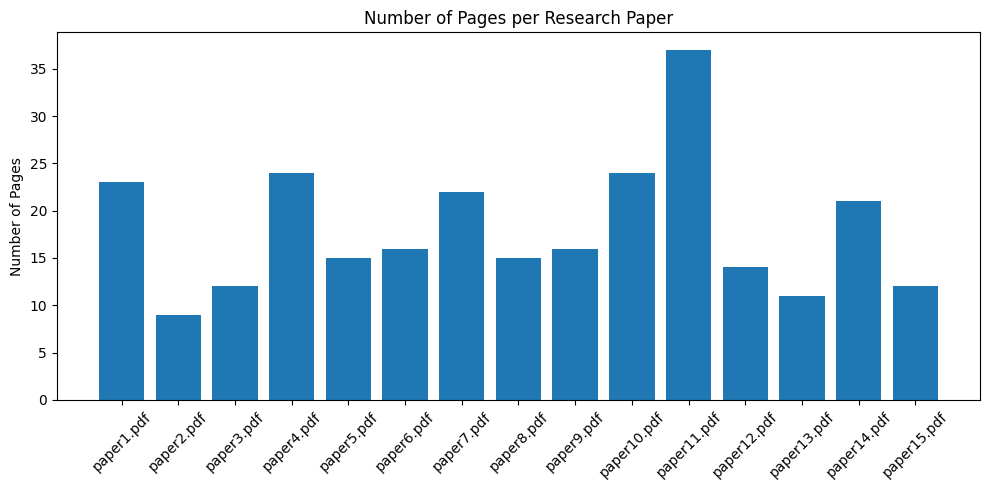

In [27]:


#df.sort_values("num_pages", inplace=True)

plt.figure(figsize=(10, 5))
plt.bar(df["filename"], df["num_pages"])
plt.xticks(rotation=45)
plt.ylabel("Number of Pages")
plt.title("Number of Pages per Research Paper")
plt.tight_layout()
plt.show()


In [25]:
# Folder containing the PDF files
pdf_folder = "Downloads/Research Papers 2"

# Initialize list to collect data
data = []

# Process each PDF file
for filename in sorted(os.listdir(pdf_folder)):
    if filename.endswith(".pdf") and filename.lower().startswith("paper"):
        file_path = os.path.join(pdf_folder, filename)

        start_time = time.time()  # ⏱️ Start timer

        doc = fitz.open(file_path)
        
        file_size_kb = round(os.path.getsize(file_path) / 1024, 2)
        num_pages = len(doc)
        total_words = 0
        font_sizes = []
        image_count = 0
        
        # Word count and font size extraction
        for page in doc:
            text = page.get_text()
            total_words += len(text.split())
            image_count += len(page.get_images(full=True))

            blocks = page.get_text("dict")["blocks"]
            for block in blocks:
                if "lines" in block:
                    for line in block["lines"]:
                        for span in line["spans"]:
                            font_sizes.append(round(span["size"], 1))
        
        words_per_page = total_words / num_pages if num_pages else 0
        parsing_time = round(time.time() - start_time, 3)  # ⏱️ End timer and round to milliseconds

        data.append({
            "filename": filename,
            "file_size_kb": file_size_kb,
            "num_pages": num_pages,
            "total_words": total_words,
            "words_per_page": words_per_page,
            "image_count": image_count,
            "avg_font_size": round(sum(font_sizes) / len(font_sizes), 2) if font_sizes else 0,
            "font_size_variance": round(pd.Series(font_sizes).std(), 2) if len(font_sizes) > 1 else 0,
            "parsing_time_sec": parsing_time  # ⏱️ Add parsing time
        })

# Create DataFrame
df = pd.DataFrame(data)

In [26]:
# Add a temporary column for sorting
df['paper_number'] = df['filename'].apply(extract_paper_number)

# Sort by paper number
df = df.sort_values('paper_number').reset_index(drop=True)

# Drop the temporary column if you don't want it
df.drop(columns='paper_number', inplace=True)

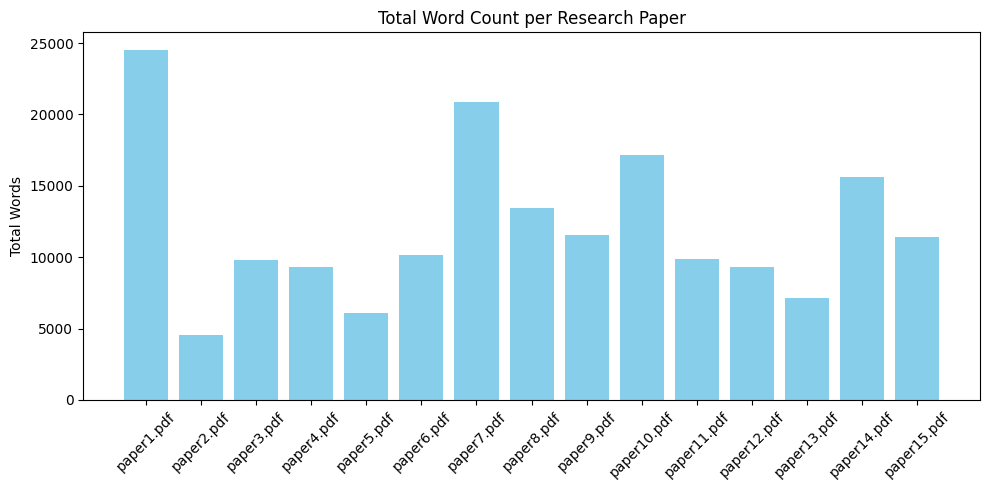

In [79]:


# Prepare plots
plt.figure(figsize=(10, 5))
plt.bar(df["filename"], df["total_words"], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Total Words")
plt.title("Total Word Count per Research Paper")
plt.tight_layout()
plt.show()



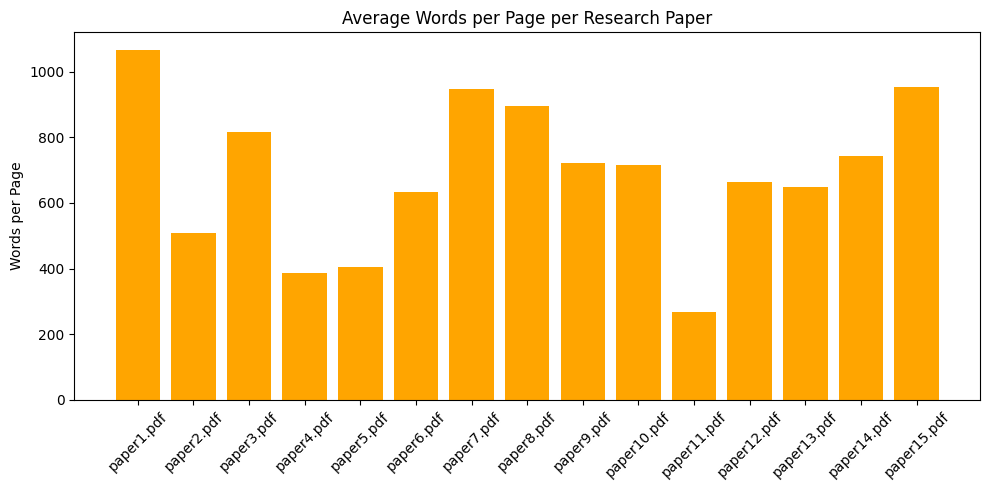

In [81]:

plt.figure(figsize=(10, 5))
plt.bar(df["filename"], df["words_per_page"], color='orange')
plt.xticks(rotation=45)
plt.ylabel("Words per Page")
plt.title("Average Words per Page per Research Paper")
plt.tight_layout()
plt.show()


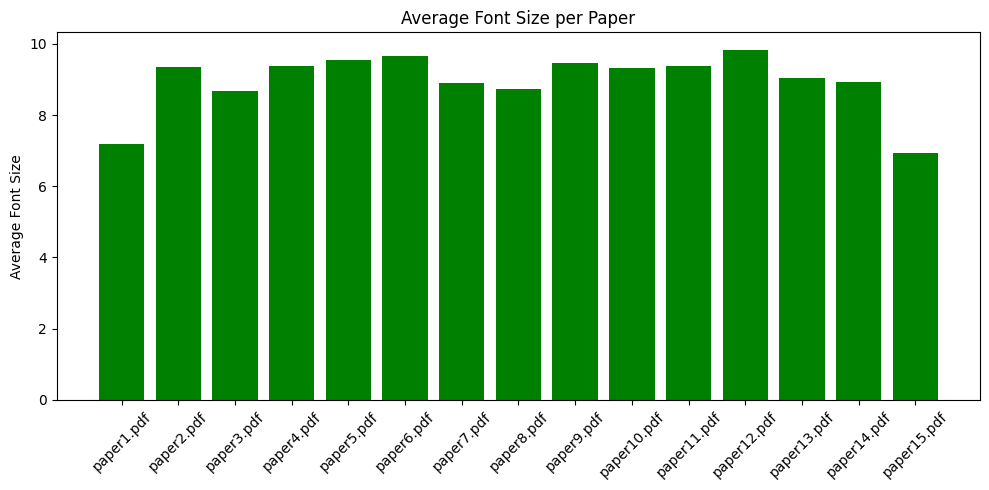

In [17]:

plt.figure(figsize=(10, 5))
plt.bar(df["filename"], df["avg_font_size"], color='green')
plt.xticks(rotation=45)
plt.ylabel("Average Font Size")
plt.title("Average Font Size per Paper")
plt.tight_layout()
plt.show()


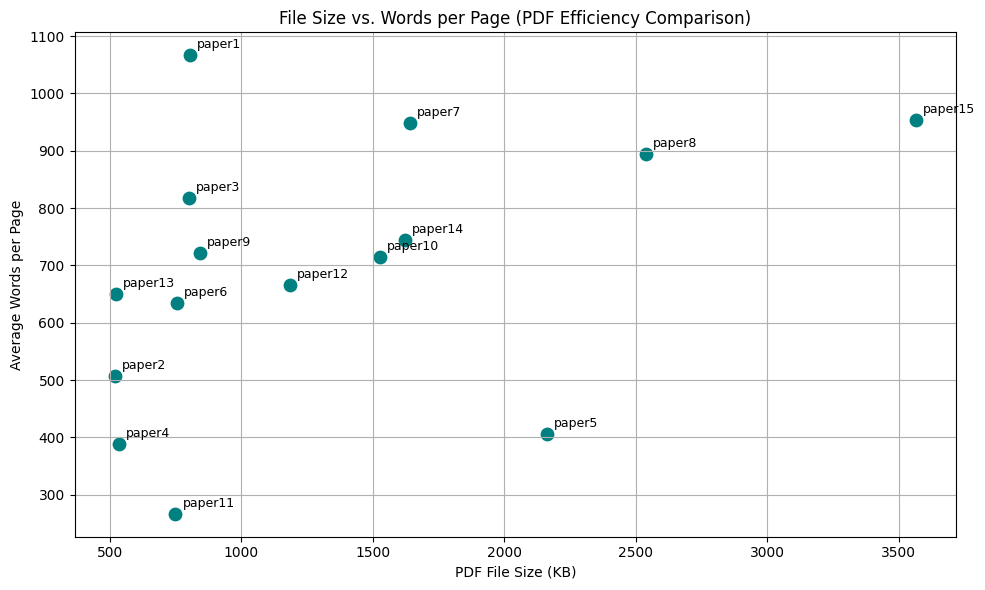

In [18]:


plt.figure(figsize=(10, 6))
plt.scatter(df["file_size_kb"], df["words_per_page"], color='teal', s=80)

# Add annotations (paper names)
for i, row in df.iterrows():
    plt.annotate(row["filename"].replace(".pdf", ""), 
                 (row["file_size_kb"], row["words_per_page"]),
                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.xlabel("PDF File Size (KB)")
plt.ylabel("Average Words per Page")
plt.title("File Size vs. Words per Page (PDF Efficiency Comparison)")
plt.grid(True)
plt.tight_layout()
plt.show()


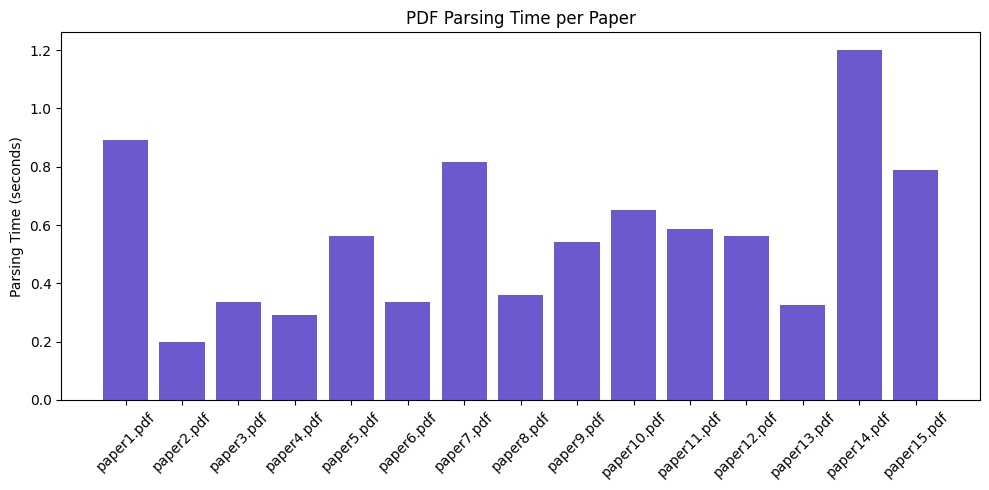

In [19]:
# Plot parsing time as a bar plot
plt.figure(figsize=(10, 5))
plt.bar(df["filename"], df["parsing_time_sec"], color='slateblue')
plt.xticks(rotation=45)
plt.ylabel("Parsing Time (seconds)")
plt.title("PDF Parsing Time per Paper")
plt.tight_layout()
plt.show()

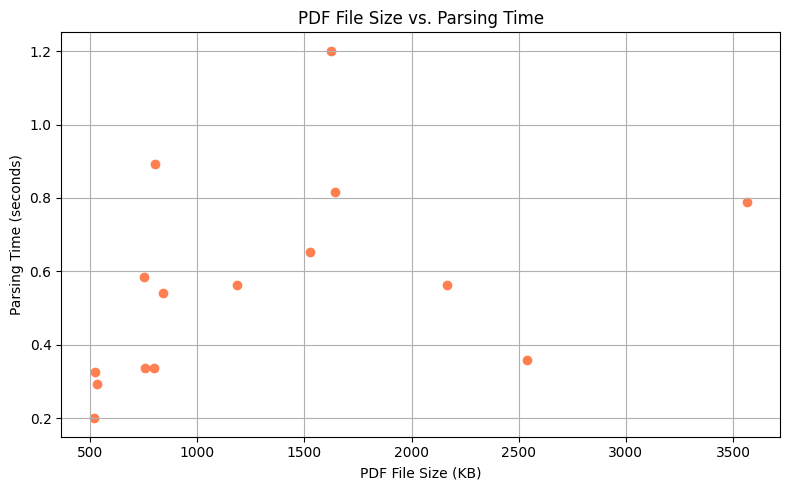

In [20]:


plt.figure(figsize=(8, 5))
plt.scatter(df["file_size_kb"], df["parsing_time_sec"], color='coral')
plt.xlabel("PDF File Size (KB)")
plt.ylabel("Parsing Time (seconds)")
plt.title("PDF File Size vs. Parsing Time")
plt.grid(True)
plt.tight_layout()
plt.show()


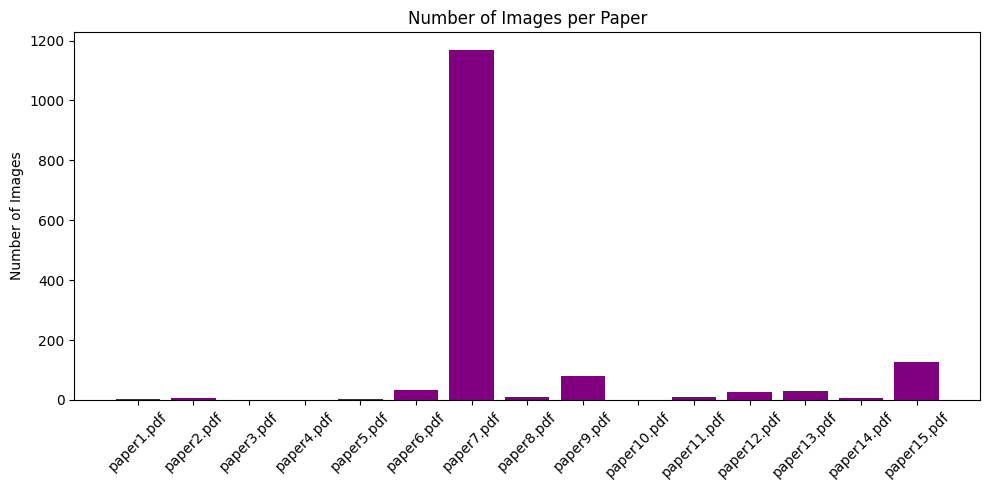

In [21]:
plt.figure(figsize=(10, 5))
plt.bar(df["filename"], df["image_count"], color='purple')
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.title("Number of Images per Paper")
plt.tight_layout()
plt.show()

In [502]:


# Reload the Word document
doc_path = "Downloads/Deepseek Online Version_Summaries.docx"
doc = Document(doc_path)

# Extract paragraphs and basic content
paragraphs = [p.text.strip() for p in doc.paragraphs if p.text.strip()]

In [31]:
# Join all paragraphs into a single string for easier pattern-based splitting
full_text = "\n".join(paragraphs)

# Use regex to split and extract each summary section
# Assumes format: Paper 1 Summary: ...content... Paper 2 Summary: ...
pattern = r"(Paper\s+\d+\s+Summary:)"
parts = re.split(pattern, full_text)



In [33]:
# Recombine parts into labeled summaries
summaries = {}
for i in range(1, len(parts), 2):  # parts[i] is the label, parts[i+1] is the content
    label = parts[i].strip().rstrip(":")
    content = parts[i + 1].strip()
    word_count = len(content.split())
    summaries[label] = {
        "summary": content,
        "word_count": word_count
    }



In [35]:
# Save to JSON
output_path = "human_written_summaries.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(summaries, f, indent=4)

output_path

'human_written_summaries.json'

In [12]:
with open("human_written_summaries.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df1 = pd.DataFrame(data)


In [14]:
df1=df1.T

In [16]:
df1.describe()

summary  word_count
count                                                  15          15
unique                                                 15          15
top     1. Detailed Breakdown of the Abstract in Simpl...        1033
freq                                                    1           1

In [18]:
df1

summary word_count
Paper 1 Summary   1. Detailed Breakdown of the Abstract in Simpl...       1033
Paper 2 Summary   1. Detailed Breakdown of the Abstract in Simpl...        765
Paper 3 Summary   1. Detailed Breakdown of the Abstract in Simpl...        750
Paper 4 Summary   1. Detailed Breakdown of the Abstract in Simpl...        754
Paper 5 Summary   1. Detailed Breakdown of the Abstract in Simpl...        768
Paper 6 Summary   1. Detailed Breakdown of the Abstract in Simpl...        809
Paper 7 Summary   1. Detailed Breakdown of the Abstract in Simpl...        868
Paper 8 Summary   1. Detailed Breakdown of the Abstract in Simpl...        837
Paper 9 Summary   1. Detailed Breakdown of the Abstract in Simpl...        897
Paper 10 Summary  1. Detailed Breakdown of the Abstract in Simpl...        888
Paper 11 Summary  1. Detailed Breakdown of the Abstract in Simpl...        758
Paper 12 Summary  1. Detailed Breakdown of the Abstract in Simpl...        955
Paper 13 Summary  1. Detailed Breakdown of the Abstract in Simpl...       1026
Paper 14 Summary  1. Detailed Breakdown of the Abstract in Simpl...        990
Paper 15 Summary  1. Detailed Breakdown of the Abstract in Simpl...        767

In [45]:
df

filename  file_size_kb  num_pages  total_words  words_per_page  \
0    paper1.pdf        803.05         23        24528     1066.434783   
1    paper2.pdf        518.05          9         4567      507.444444   
2    paper3.pdf        800.18         12         9805      817.083333   
3    paper4.pdf        534.24         24         9307      387.791667   
4    paper5.pdf       2163.32         15         6095      406.333333   
5    paper6.pdf        757.00         16        10152      634.500000   
6    paper7.pdf       1642.34         22        20867      948.500000   
7    paper8.pdf       2538.92         15        13414      894.266667   
8    paper9.pdf        842.54         16        11549      721.812500   
9   paper10.pdf       1527.71         24        17151      714.625000   
10  paper11.pdf        749.61         37         9872      266.810811   
11  paper12.pdf       1185.13         14         9311      665.071429   
12  paper13.pdf        523.25         11         7144      649.454545   
13  paper14.pdf       1623.60         21        15618      743.714286   
14  paper15.pdf       3566.40         12        11443      953.583333   

    image_count  avg_font_size  font_size_variance  parsing_time_sec  
0             3           7.18                0.82             0.863  
1             6           9.36                1.24             0.187  
2             0           8.68                1.77             0.341  
3             0           9.38                1.49             0.299  
4             3           9.54                1.09             0.574  
5            34           9.67                1.99             0.341  
6          1169           8.90                1.34             0.858  
7             9           8.73                1.32             0.385  
8            80           9.46                1.43             0.563  
9             0           9.31                1.70             1.054  
10           11           9.38                0.70             0.629  
11           26           9.83                1.20             0.591  
12           29           9.04                1.79             0.342  
13            6           8.92                1.19             1.330  
14          127           6.92                1.64             0.807

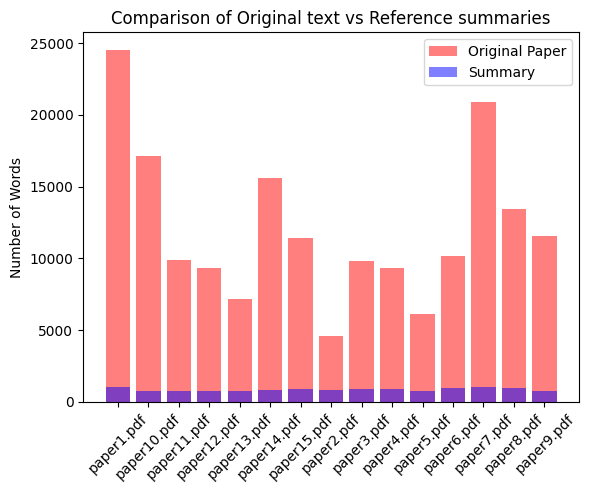

In [53]:
plt.bar(df["filename"], df["total_words"], color='red',alpha=0.5,label="Original Paper")
plt.bar(df["filename"], df1["word_count"], color='blue',alpha=0.5,label="Summary")
plt.xticks(rotation=45)
plt.ylabel("Number of Words")
plt.title("Comparison of Original text vs Reference summaries")
plt.legend()
plt.show()

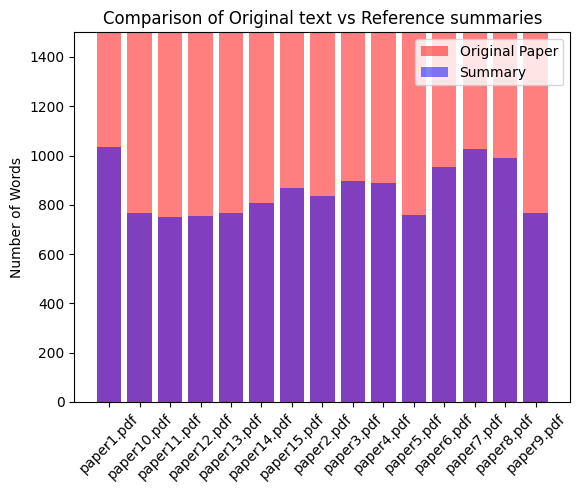

In [55]:
plt.bar(df["filename"], df["total_words"], color='red',alpha=0.5,label="Original Paper")
plt.bar(df["filename"], df1["word_count"], color='blue',alpha=0.5,label="Summary")
plt.xticks(rotation=45)
plt.ylabel("Number of Words")
plt.ylim(0,1500)
plt.title("Comparison of Original text vs Reference summaries")
plt.legend()
plt.show()

## Extracting summary from .docx files

In [508]:
# Folder containing the .docx files
docx_folder = "Downloads/sample"  # Update this with the actual folder path

# Get all .docx files in the folder
docx_files = [f for f in os.listdir(docx_folder) if f.endswith(".docx")]

# Initialize a dictionary to store DataFrames for the Excel file
model_dataframes = {}




In [509]:
# 📌 Define the regex pattern for detecting section headers (to exclude)
separator_pattern = (
    r"(Paper\s+\d+\s+Summary:\s*\n*"
    r"Extracting structured text from PDF\.\.\.\s*\n*"
    r"Structured text saved to structured_paper\.txt\s*\n*"
    r"Generating summary\.\.\.\s*\n*"
    r"--- Summary of the Research Paper ---)"
)

# 📌 Define regex pattern to detect and extract "Time taken" statement
time_pattern = r"Time taken for summarization:\s*([\d.]+)\s*seconds"

# 🚀 Process each .docx file (each representing a different model)
for docx_file in docx_files:
    file_path = os.path.join(docx_folder, docx_file)
    doc = Document(file_path)
    
    # 📝 Read the document into a single string for easier processing
    full_text = "\n".join([p.text.strip() for p in doc.paragraphs if p.text.strip()])
    
    # 🛠️ Use regex to split text based on "Paper X Summary:" while excluding the separator text
    parts = re.split(separator_pattern, full_text)

    # 📝 Store extracted summaries
    extracted_summaries = []
    
    for i in range(1, len(parts), 2):  # parts[i] contains "Paper X Summary", parts[i+1] contains text
        paper_number = parts[i].strip().rstrip(":")  # Extract "Paper X Summary"
        summary_content = parts[i + 1].strip()

        # ⏳ Extract time taken for summarization (if present)
        time_match = re.search(time_pattern, summary_content)
        time_taken = float(time_match.group(1)) if time_match else None

        # ❌ Remove the "Time taken" statement from summary text
        summary_content = re.sub(time_pattern, "", summary_content).strip()

        # 🔢 Count words in the summary
        word_count = len(summary_content.split())

        # 📥 Append extracted information to list
        extracted_summaries.append([paper_number, summary_content, word_count, time_taken])
    
    # 📊 Create DataFrame
    df = pd.DataFrame(extracted_summaries, columns=["Paper Number", "Summary Text", "Word Count", "Summarization Time (sec)"])

    # 💾 Save as an individual CSV file (🔹 SAME NAME as original .docx file)
    csv_filename = os.path.join(docx_folder, f"{os.path.splitext(docx_file)[0]}.csv")
    df.to_csv(csv_filename, index=False, encoding="utf-8")
    print(f"✅ Saved CSV: {csv_filename}")

    # 📂 Store DataFrame for final Excel file
    model_name = os.path.splitext(docx_file)[0]  # Extract model name from filename
    model_dataframes[model_name] = df

In [505]:

# 🔁 Replace this with the full path to your JSON file
json_path = "Downloads/sample/summarized_papers.json"




In [53]:
# 📥 Load the JSON data
with open(json_path, "r", encoding="utf-8") as f:
    paper_summaries = json.load(f)



In [55]:
# 📊 Prepare the rows for the DataFrame
rows = []
for paper in paper_summaries:
    filename = paper["filename"]
    
    # 🧠 Extract paper number (e.g., "paper1" from "paper1.pdf")
    match = re.search(r"(paper\d+)", filename.lower())
    paper_number = match.group(1) if match else filename

    summary_text = paper["summary"]
    summary_time = paper["summarization_time_sec"]
    
    # Detect model name from JSON (should be consistent)
    model_name = paper.get("model_used", "mistral")
    word_count_key = f"summary_word_count_{model_name}"
    word_count = paper.get(word_count_key, len(summary_text.split()))

    rows.append({
        "Paper Number": paper_number,
        "Summary Text": summary_text,
        "Word Count": word_count,
        "Summarization Time (sec)": summary_time
    })

# 🧾 Create a DataFrame
df = pd.DataFrame(rows)

# 💾 Save as CSV in the same directory
csv_path = os.path.join(os.path.dirname(json_path), "Mistral_Summary.csv")
df.to_csv(csv_path, index=False, encoding="utf-8")

print(f"✅ CSV file saved to: {csv_path}")

✅ CSV file saved to: Downloads/sample/Mistral_Summary.csv


## Prompt Engineering

In [190]:
# 1. Pull reference summaries out of df1
#    (assumes df1 has a column named 'summary' with the reference text)
reference_summaries = df1['summary'].tolist()


In [192]:
# 2. Prepare scorers
rouge = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
bert_scorer = BERTScorer(lang='en', rescale_with_baseline=True)
#score(candidate_text, reference_text, lang="en", verbose=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [194]:
# 3. Folders to process
root_dir = "Downloads/"
prompt_folders = ['Prompt1', 'Prompt2','Prompt3', 'Prompt4']

In [196]:
# 3. Compute & save metrics (skip if already done)
for folder in prompt_folders:
    folder_path = os.path.join(root_dir, folder)
    for csv_path in glob.glob(os.path.join(folder_path, 'summarized_papers_*.csv')):
        model = os.path.splitext(os.path.basename(csv_path))[0].split('summarized_papers_')[-1]
        out_csv = os.path.join(folder_path, f"{model}_metrics_data.csv")
        
        # Skip if metrics file already exists
        if os.path.exists(out_csv):
            print(f"Skipping {model} in {folder} (metrics already exist).")
            continue
        
        gen_df = pd.read_csv(csv_path)
        generated = gen_df['summary_text'].tolist()
        
        # ROUGE
        r1, r2, rL = [], [], []
        for ref, hyp in zip(reference_summaries, generated):
            s = rouge.score(ref, hyp)
            r1.append(s['rouge1'].fmeasure)
            r2.append(s['rouge2'].fmeasure)
            rL.append(s['rougeL'].fmeasure)
        
        # BERTScore
        #P, R, F1 = bert_scorer.score(generated, reference_summaries)
        P, R, F1=score(generated, reference_summaries, lang="en", verbose=True)
        
        # Attach metrics
        gen_df['rouge1_fmeasure']      = r1
        gen_df['rouge2_fmeasure']      = r2
        gen_df['rougeL_fmeasure']      = rL
        gen_df['bertscore_precision']  = P.tolist()
        gen_df['bertscore_recall']     = R.tolist()
        gen_df['bertscore_f1']         = F1.tolist()

        # ← New: average of the three BERTScore values
        gen_df['bertscore_avg'] = (
            gen_df['bertscore_precision'] +
            gen_df['bertscore_recall'] +
            gen_df['bertscore_f1']
        ) / 3
        # Save
        gen_df.to_csv(out_csv, index=False)
        print(f"Saved metrics for {model} in {folder} → {out_csv}")

Skipping mistral in Prompt1 (metrics already exist).
Skipping qwen2.5 in Prompt1 (metrics already exist).
Skipping gemma3 in Prompt1 (metrics already exist).


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 13.72 seconds, 1.09 sentences/sec
Saved metrics for deepseek-r1(8b) in Prompt1 → Downloads/Prompt1/deepseek-r1(8b)_metrics_data.csv
Skipping llama3.2 in Prompt1 (metrics already exist).
Skipping llama3.1 in Prompt1 (metrics already exist).
Skipping mistral in Prompt2 (metrics already exist).
Skipping qwen2.5 in Prompt2 (metrics already exist).
Skipping gemma3 in Prompt2 (metrics already exist).


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 12.76 seconds, 1.18 sentences/sec
Saved metrics for deepseek-r1(8b) in Prompt2 → Downloads/Prompt2/deepseek-r1(8b)_metrics_data.csv
Skipping llama3.2 in Prompt2 (metrics already exist).
Skipping llama3.1 in Prompt2 (metrics already exist).


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 13.38 seconds, 1.12 sentences/sec
Saved metrics for mistral in Prompt3 → Downloads/Prompt3/mistral_metrics_data.csv


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 12.65 seconds, 1.19 sentences/sec
Saved metrics for qwen2.5 in Prompt3 → Downloads/Prompt3/qwen2.5_metrics_data.csv


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 12.82 seconds, 1.17 sentences/sec
Saved metrics for gemma3 in Prompt3 → Downloads/Prompt3/gemma3_metrics_data.csv


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 13.04 seconds, 1.15 sentences/sec
Saved metrics for deepseek-r1(8b) in Prompt3 → Downloads/Prompt3/deepseek-r1(8b)_metrics_data.csv


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 12.93 seconds, 1.16 sentences/sec
Saved metrics for llama3.2 in Prompt3 → Downloads/Prompt3/llama3.2_metrics_data.csv


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 13.24 seconds, 1.13 sentences/sec
Saved metrics for llama3.1 in Prompt3 → Downloads/Prompt3/llama3.1_metrics_data.csv
Skipping Mistral in Prompt4 (metrics already exist).
Skipping qwen2.5 in Prompt4 (metrics already exist).
Skipping gemma3 in Prompt4 (metrics already exist).


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 13.04 seconds, 1.15 sentences/sec
Saved metrics for deepseek-r1(8b) in Prompt4 → Downloads/Prompt4/deepseek-r1(8b)_metrics_data.csv
Skipping llama3.2 in Prompt4 (metrics already exist).
Skipping llama3.1 in Prompt4 (metrics already exist).


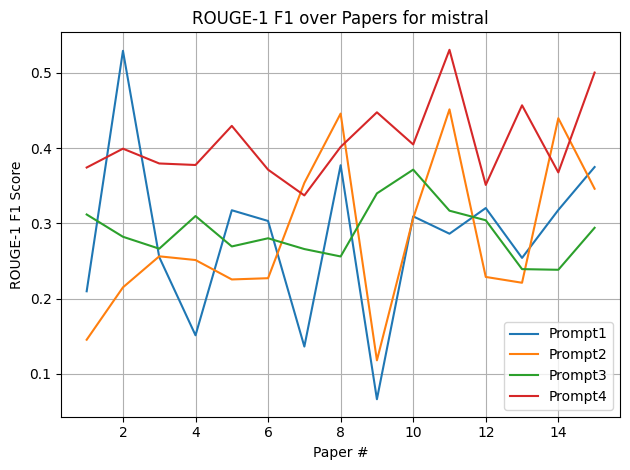

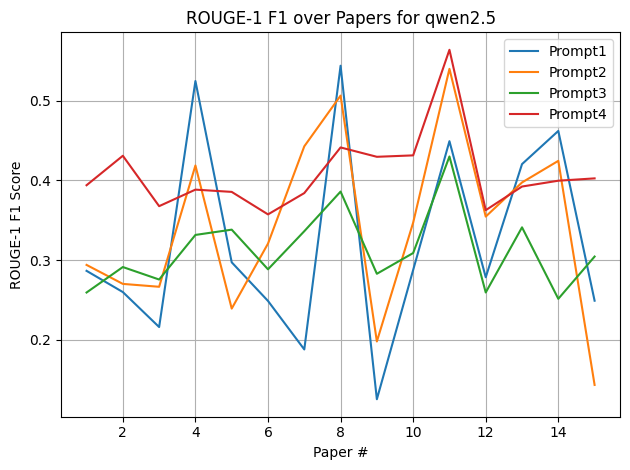

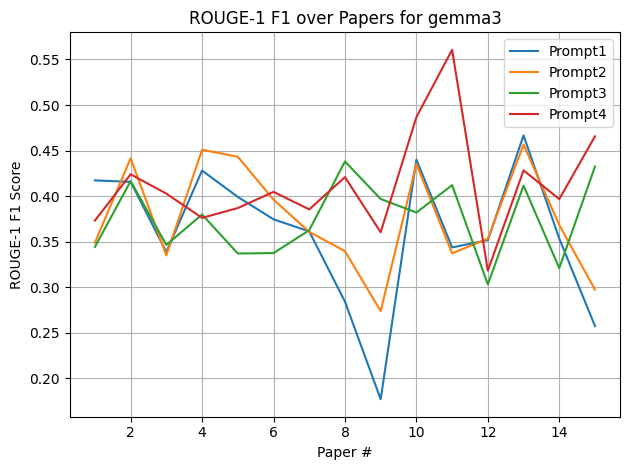

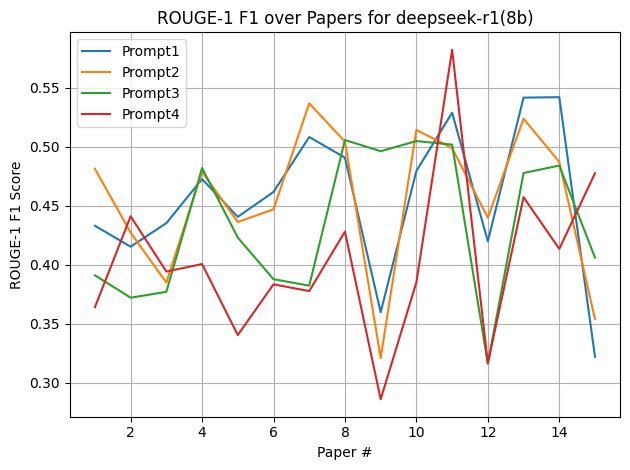

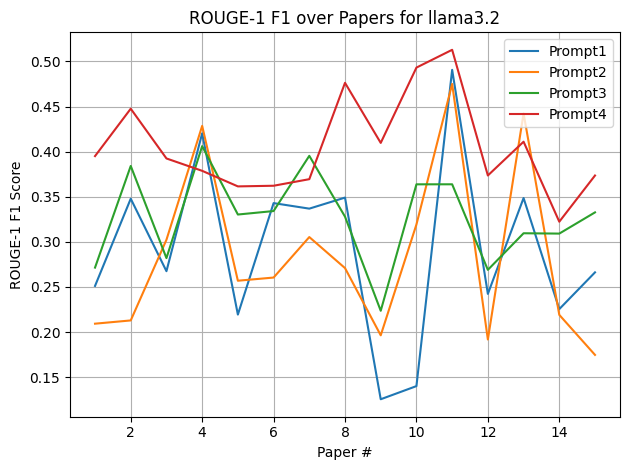

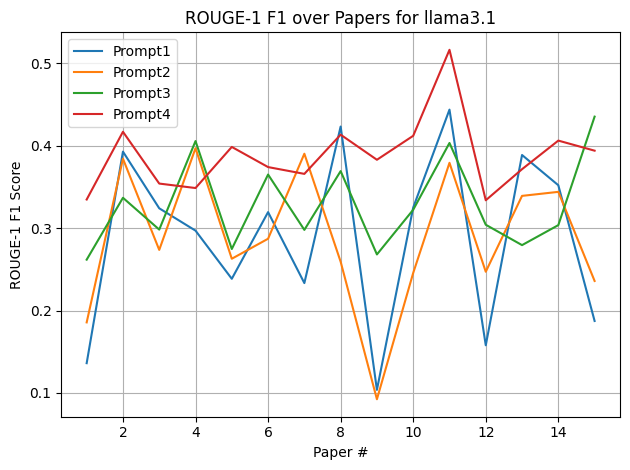

In [198]:
model_names = [
    os.path.splitext(os.path.basename(p))[0].split('summarized_papers_')[-1]
    for p in glob.glob(os.path.join(root_dir, 'Prompt1', 'summarized_papers_*.csv'))
]

for model in model_names:
    plt.figure()
    for folder in prompt_folders:
        metrics_fp = os.path.join(root_dir, folder, f"{model}_metrics_data.csv")
        dfm = pd.read_csv(metrics_fp)
        x = range(1, len(dfm)+1)
        y = dfm['rouge1_fmeasure']
        plt.plot(x, y, label=folder)
    
    plt.title(f"ROUGE-1 F1 over Papers for {model}")
    plt.xlabel("Paper #")
    plt.ylabel("ROUGE-1 F1 Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [232]:
import os, glob, pandas as pd, matplotlib.pyplot as plt

def plot_metric_grid(
    root_dir: str,
    prompt_folders: list[str],
    metric_col: str,
    metric_label: str,
    model_pattern: str = 'summarized_papers_*.csv',
    nrows: int = 2,
    ncols: int = 3,
    figsize: tuple = (18, 10)
):
    # 1. Discover model names from Prompt1
    pattern = os.path.join(root_dir, 'Prompt1', model_pattern)
    model_names = [
        os.path.splitext(os.path.basename(p))[0].split('summarized_papers_')[-1]
        for p in glob.glob(pattern)
    ]
    
    # 2. Create grid
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)
    axes_flat = axes.flatten()
    
    # 3. Plot each model
    for idx, (ax, model) in enumerate(zip(axes_flat, model_names)):
        # Load & plot each prompt’s curve
        for folder in prompt_folders:
            fp = os.path.join(root_dir, folder, f"{model}_metrics_data.csv")
            if not os.path.exists(fp):
                continue
            dfm = pd.read_csv(fp)
            x = list(range(1, len(dfm) + 1))
            y = dfm[metric_col]
            ax.plot(x, y, marker='o', label=folder)
        
        # xticks and limits
        ax.set_xticks(x)
        ax.set_xlim(1, len(dfm))
        
        # Title
        ax.set_title(model, fontsize=18)
        
        # Determine row/col of this subplot
        row, col = divmod(idx, ncols)
        
        # y-label on leftmost column only
        if col == 0:
            ax.set_ylabel(metric_label, fontsize=16)
        else:
            ax.set_ylabel('')  # or simply omit
        
        # x-label on bottom row only
        if row == nrows - 1:
            ax.set_xlabel("Paper Number", fontsize=16)
        else:
            ax.set_xlabel('')
        
        # Ticks
        ax.tick_params(axis='x', rotation=45, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        
        # Grid + legend (with larger font)
        ax.grid(True)
        ax.legend(fontsize=15)
    
    # 4. Turn off any unused axes
    for ax in axes_flat[len(model_names):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


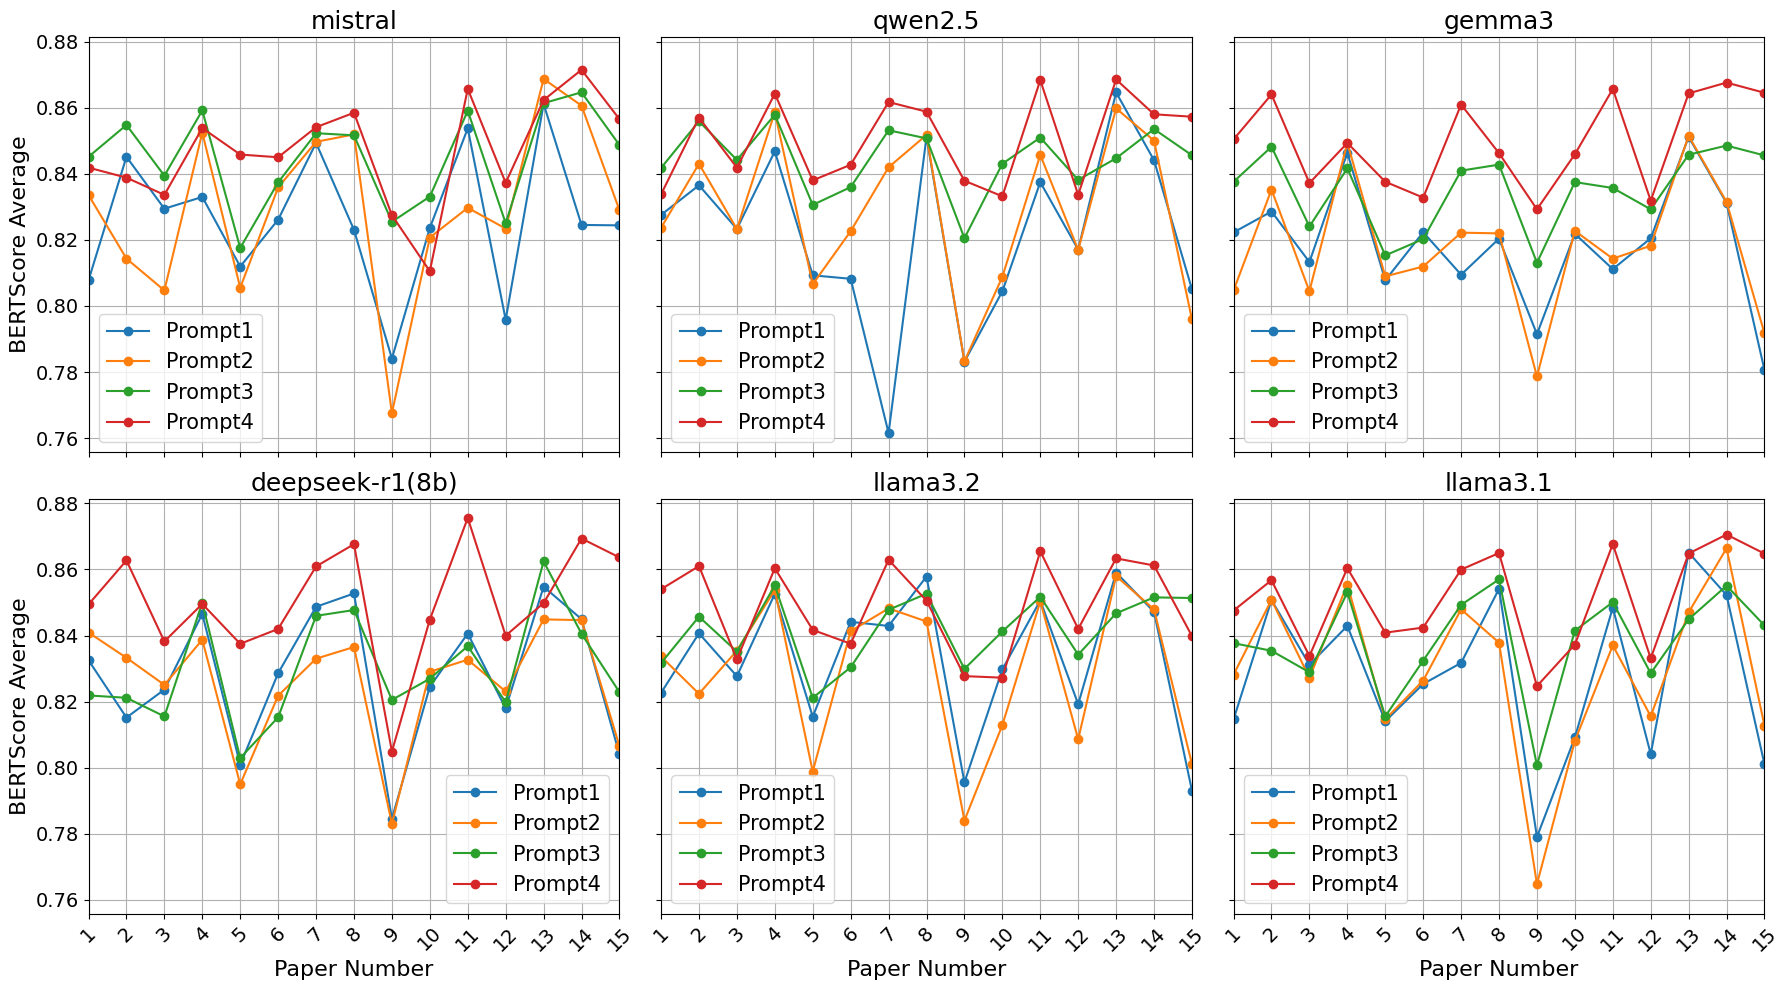

In [234]:
#BERTScore F1,ROUGE-L F1 Score,ROUGE-2 F1 Score,'ROUGE-1 F1 Score'
# Plot all six models in a 2×3 grid for ROUGE-1:
plot_metric_grid(
    root_dir=root_dir,
    prompt_folders=prompt_folders,
    metric_col='bertscore_avg',
    metric_label='BERTScore Average'
)

In [512]:

def compute_scores(reference, candidate):
    # Initialize ROUGE scorer
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(reference, candidate)

    # Tokenize for BLEU and METEOR
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    
    # Compute BLEU score
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)
    
    
    
    # Compute BERTScore (using GPU if available)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    P, R, F1 = score(
        [candidate], 
        [reference], 
        lang='en', 
        verbose=True
    )
    bert_score = F1.mean().item()  # Using F1 as the main BERTScore metric

    return {
        "ROUGE-1": rouge_scores["rouge1"].fmeasure,
        "ROUGE-2": rouge_scores["rouge2"].fmeasure,
        "ROUGE-L": rouge_scores["rougeL"].fmeasure,
        "BLEU": bleu_score,
        "BERTScore": bert_score
    }

In [166]:


# Define two texts
reference_text = ["This is the original reference sentence."]
candidate_text = ["This sentence is similar to the reference sentence."]

# Calculate BERTScore
P, R, F1 = score(candidate_text, reference_text, lang="en", verbose=True)
# BERTScore
P, R, F1 = bert_scorer.score(candidate_text, reference_text, verbose=True)

# Print scores
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall: {R.mean().item():.4f}")
print(f"F1 Score: {F1.mean().item():.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 3.72 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 6.00 sentences/sec
Precision: 0.4971
Recall: 0.5640
F1 Score: 0.5311


In [ ]:
# Folder containing model-generated summary CSV files
docx_folder = "Downloads/sample/model summaries"  # 🔁 Update with your local path
Output_folder="Downloads/sample/model metrics"

# 🧾 Load human-written summaries (assumed to have 'summary' column)
reference_summaries = df1["summary"].tolist()

# 🧪 Store results
results = {}
# 🔄 Loop through model files
for filename in os.listdir(docx_folder):
    if filename.endswith(".csv") and "_metrics_data" not in filename:
        model_name = os.path.splitext(filename)[0]
        file_path = os.path.join(docx_folder, filename)

        # Load model-generated summaries
        model_df = pd.read_csv(file_path)

        # Collect final rows
        rows = []
        for i in range(min(len(reference_summaries), len(model_df))):
            paper_number = f"paper{i+1}"
            reference = reference_summaries[i]
            candidate = model_df.loc[i, "Summary Text"]

            # Get existing word count & time
            word_count = model_df.loc[i, "Word Count"]
            time_taken = model_df.loc[i, "Summarization Time (sec)"]

            # Compute ROUGE & BLEU
            scores = compute_scores(reference, candidate)

            # Combine everything
            row = {
                "Paper Number": paper_number,
                "Word Count": word_count,
                "Summarization Time (sec)": time_taken,
                **scores
            }
            rows.append(row)

        # Save combined results
        results_df = pd.DataFrame(rows).set_index("Paper Number")
        csv_output_path = os.path.join(Output_folder, f"{model_name}_metrics_data.csv")
        results_df.to_csv(csv_output_path)
        print(f"✅ Saved: {csv_output_path}")

        results[model_name] = results_df

# (Optional) Preview combined results
combined_df = pd.concat(results, names=["Model", "Paper Number"])
print("\n🔍 Combined ROUGE & BLEU Scores Preview:")
print(combined_df.head())

INFO:absl:Using default tokenizer.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:absl:Using default tokenizer.


done in 4.50 seconds, 0.22 sentences/sec


In [516]:
# Folder where the per‑model metric CSVs live
metrics_folder = "Downloads/sample/model metrics"   # 🔁 adjust if needed

# Dict to collect each model’s DataFrame
results = {}

for filename in os.listdir(metrics_folder):
    # We only want the files produced earlier, e.g.  bert_large_metrics_data.csv
    if filename.endswith("_metrics_data.csv"):
        model_name = filename.replace("_metrics_data.csv", "")
        file_path  = os.path.join(metrics_folder, filename)

        # Each CSV was saved with "Paper Number" already as the index
        df = pd.read_csv(file_path, index_col="Paper Number")

        # Store under the model’s name
        results[model_name] = df

# Stack everything into one tidy multi‑index DataFrame
combined_df = pd.concat(results, names=["Model", "Paper Number"])

# --- Optional: quick sanity check ---
print("Combined DataFrame preview:")
print(combined_df.head())

Combined DataFrame preview:
                     Word Count  Summarization Time (sec)   ROUGE-1   ROUGE-2  \
Model  Paper Number                                                             
Gemma3 paper1               389                     48.52  0.373186  0.113495   
       paper2               303                     41.58  0.423963  0.168052   
       paper3               376                     50.57  0.402719  0.105532   
       paper4               318                     46.09  0.376147  0.154412   
       paper5               338                     43.78  0.386874  0.119377   

                      ROUGE-L      BLEU  BERTScore  
Model  Paper Number                                 
Gemma3 paper1        0.185211  0.018919   0.850391  
       paper2        0.224885  0.021734   0.863953  
       paper3        0.183517  0.022949   0.837168  
       paper4        0.203670  0.025237   0.849315  
       paper5        0.188256  0.016598   0.837517  


In [518]:
# Display all results with better formatting
def display_all_results(combined_df):
    # Display settings for pandas
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_rows', None)
    
    print("\n" + "="*80)
    print("📊 COMPLETE EVALUATION RESULTS")
    print("="*80 + "\n")
    
    # 1. Display all individual paper results
    print("📄 Individual Paper Results:")
    with pd.option_context('display.float_format', '{:.4f}'.format):
        print(combined_df)
    
    # 2. Calculate and display average metrics per model
    print("\n" + "-"*80)
    print("📈 Average Metrics by Model:")
    avg_metrics = combined_df.groupby(level=0).mean()
    with pd.option_context('display.float_format', '{:.4f}'.format):
        print(avg_metrics)
    
    # 3. Display overall statistics
    print("\n" + "-"*80)
    print("🧮 Overall Statistics Across All Models:")
    overall_stats = combined_df.describe()
    with pd.option_context('display.float_format', '{:.4f}'.format):
        print(overall_stats)
    
    # 4. Display metric correlations
    print("\n" + "-"*80)
    print("🔗 Metric Correlations:")
    corr_matrix = combined_df.corr()
    with pd.option_context('display.float_format', '{:.2f}'.format):
        print(corr_matrix)
    
    # 5. Best performing model for each metric
    print("\n" + "-"*80)
    print("🏆 Best Performing Models by Metric:")
    best_models = avg_metrics.idxmax()
    print(best_models.to_string())

# Call the display function
display_all_results(combined_df)


📊 COMPLETE EVALUATION RESULTS

📄 Individual Paper Results:
                              Word Count  Summarization Time (sec)  ROUGE-1  ROUGE-2  ROUGE-L   BLEU  BERTScore
Model           Paper Number                                                                                   
Gemma3          paper1               389                   48.5200   0.3732   0.1135   0.1852 0.0189     0.8504
                paper2               303                   41.5800   0.4240   0.1681   0.2249 0.0217     0.8640
                paper3               376                   50.5700   0.4027   0.1055   0.1835 0.0229     0.8372
                paper4               318                   46.0900   0.3761   0.1544   0.2037 0.0252     0.8493
                paper5               338                   43.7800   0.3869   0.1194   0.1883 0.0166     0.8375
                paper6               412                   52.0300   0.4047   0.1013   0.1642 0.0114     0.8328
                paper7               299    

## Visualization of model performance

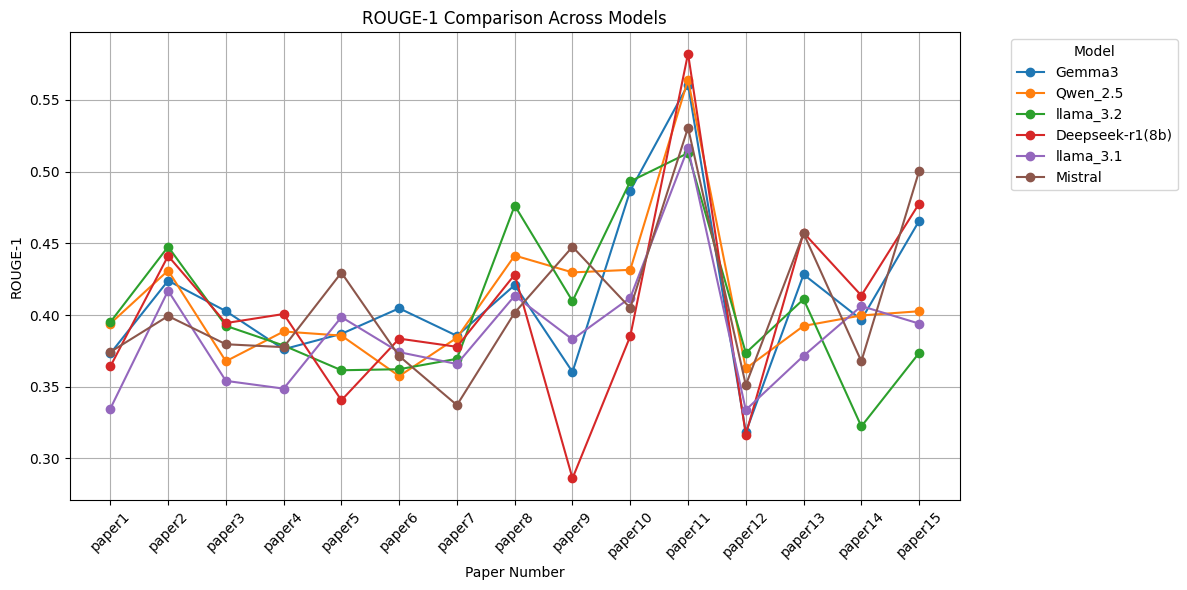

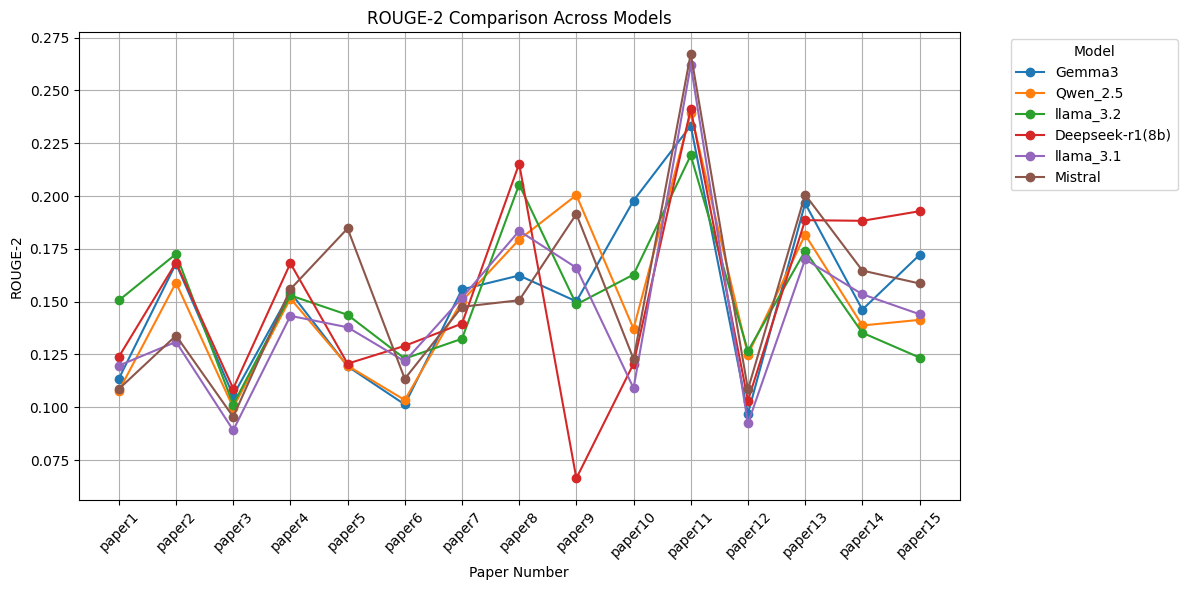

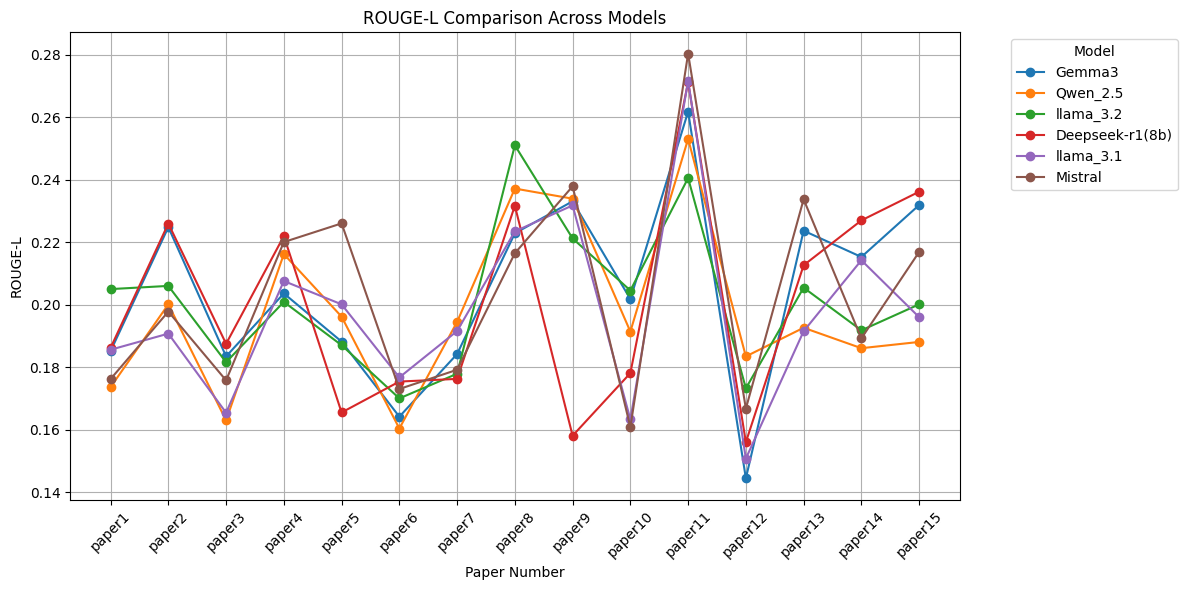

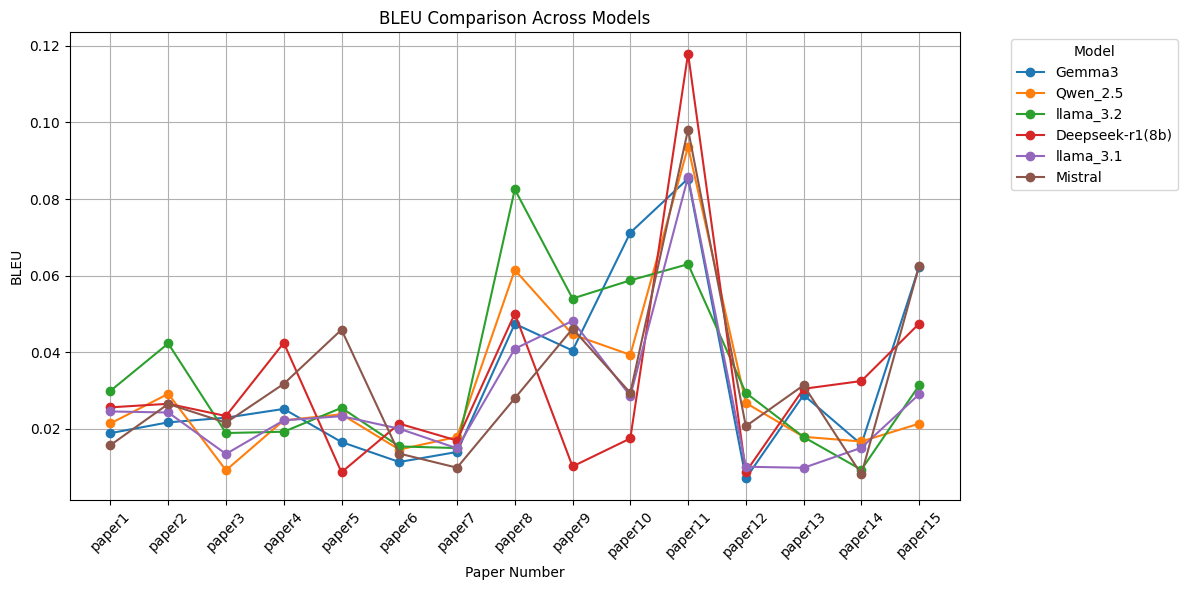

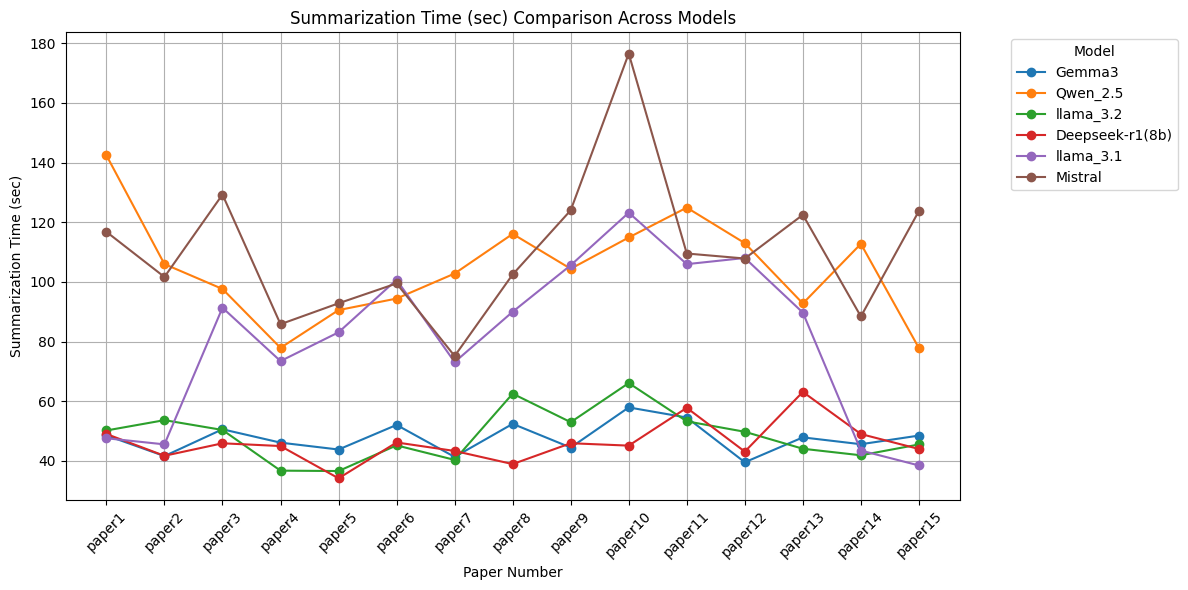

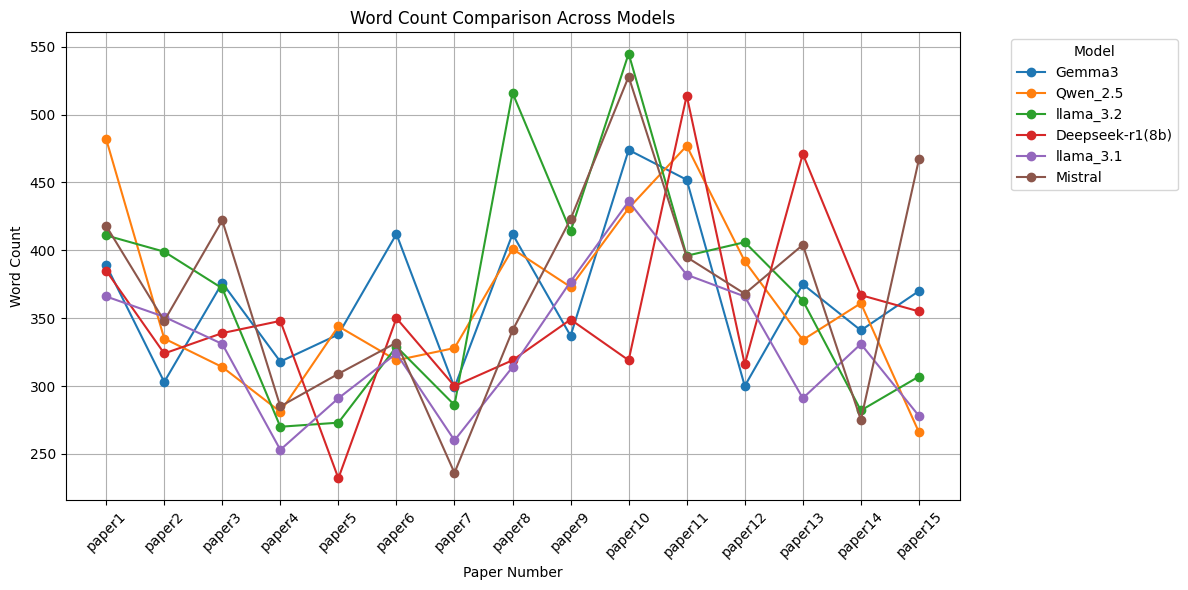

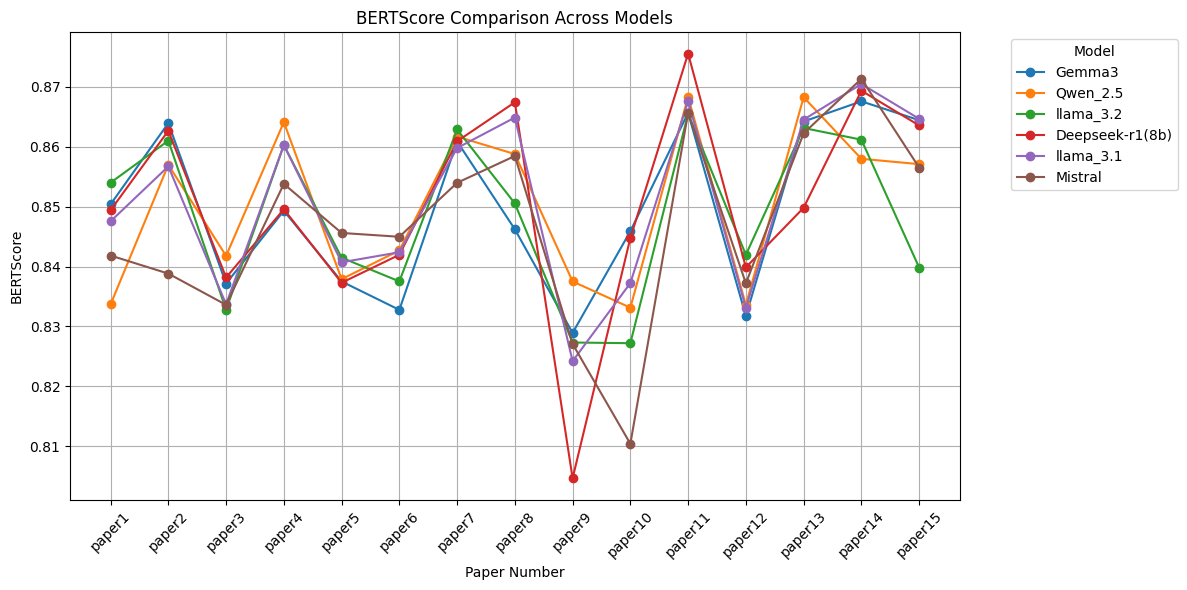

In [520]:


# Path where the 6 model CSVs are saved
csv_folder = "Downloads/sample/model metrics"  # 🔁 Update this path as needed

# Metrics to visualize
metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "Summarization Time (sec)", "Word Count","BERTScore"]

# Read all *_ROUGE_BLEU.csv files
model_data = {}
for file in os.listdir(csv_folder):
    if file.endswith("_metrics_data.csv"):
        model_name = file.replace("_metrics_data.csv", "")
        df = pd.read_csv(os.path.join(csv_folder, file))
        df["Paper Number"] = df.index if "Paper Number" not in df.columns else df["Paper Number"]
        df.set_index("Paper Number", inplace=True)
        model_data[model_name] = df

for metric in metrics:
    plt.figure(figsize=(12, 6))

    for model_name, df in model_data.items():
        # Sort papers numerically: paper1, paper2, ..., paper15
        df_sorted = df.copy()
        df_sorted["sort_key"] = df_sorted.index.str.extract(r'(\d+)').astype(int)
        df_sorted = df_sorted.sort_values("sort_key").drop(columns="sort_key")

        plt.plot(df_sorted.index, df_sorted[metric], marker='o', label=model_name)

    plt.title(f"{metric} Comparison Across Models")
    plt.xlabel("Paper Number")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



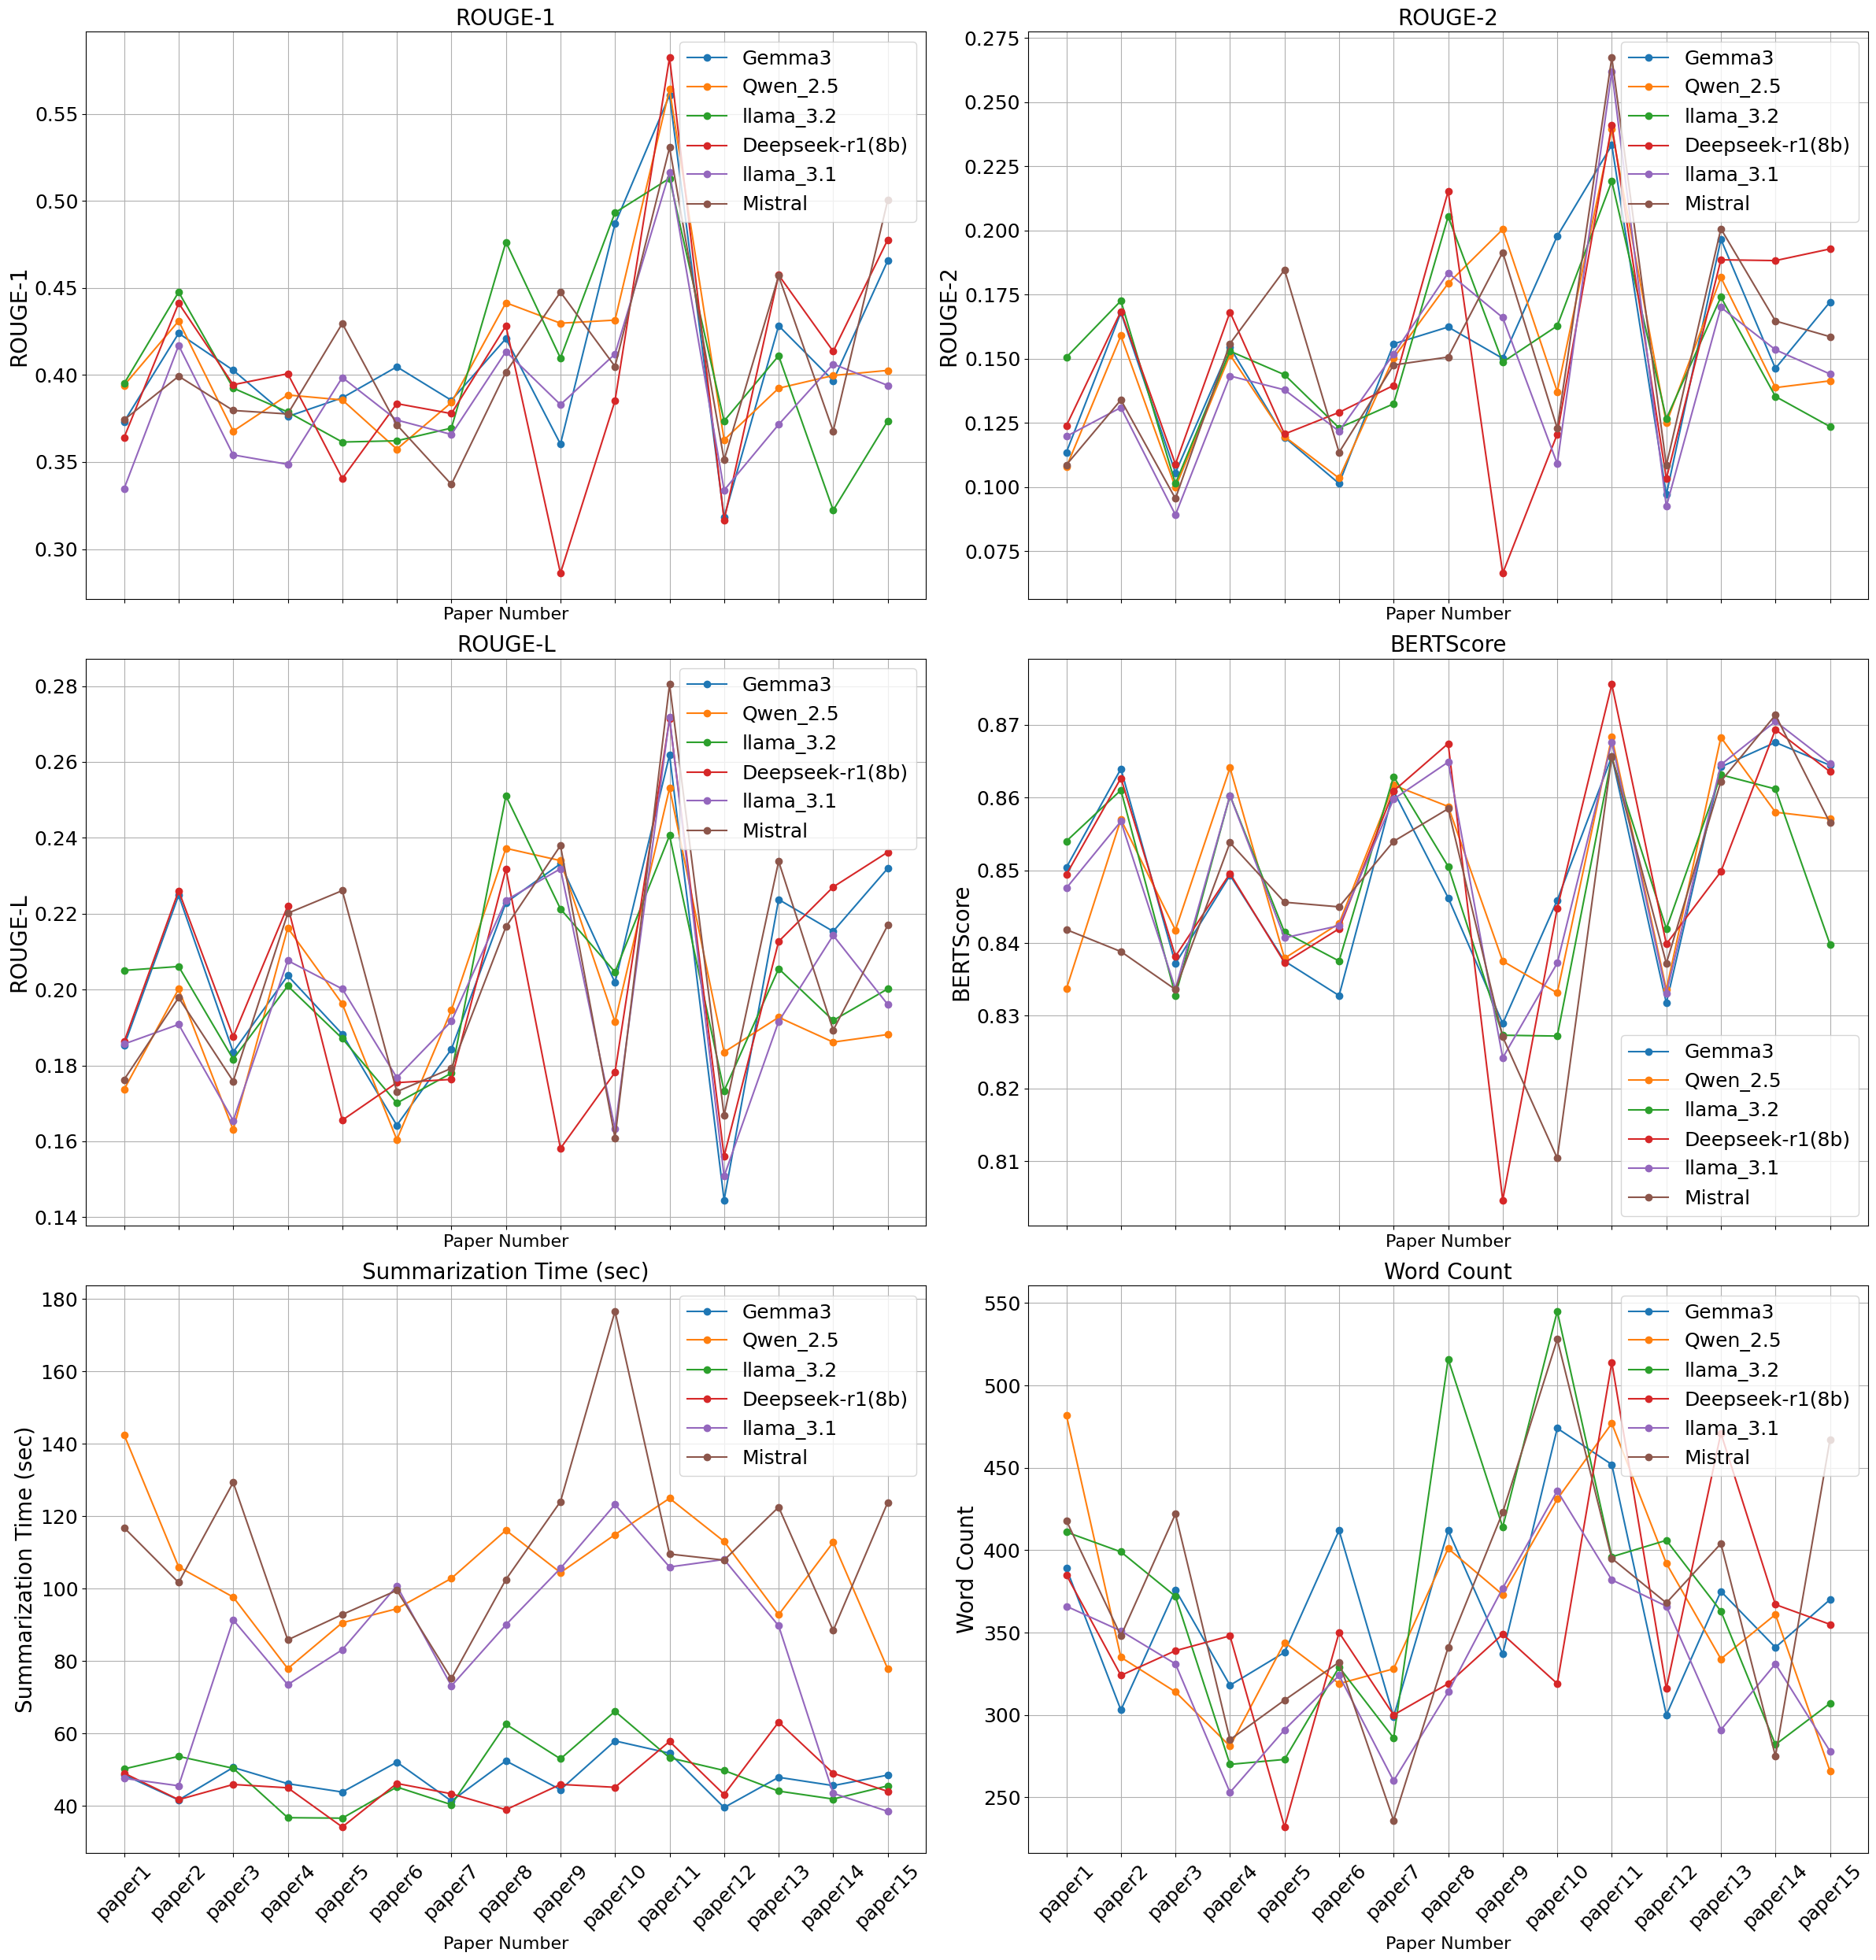

In [244]:
# ——— CONFIG ———
csv_folder = "Downloads/sample/model metrics"  # 🔁 Update this as needed

# Metrics to visualize (first 6 will be plotted in a 2×3 grid)
metrics = [
    "ROUGE-1",
    "ROUGE-2",
    "ROUGE-L",
    "BERTScore",
    "Summarization Time (sec)",
    "Word Count",
    # "BERTScore"  # ← if you want to include BERTScore, adjust grid to 3×3
]

# 1. Load all metrics CSVs in the folder
model_data = {}
for fname in os.listdir(csv_folder):
    if fname.endswith("_metrics_data.csv"):
        model_name = fname.replace("_metrics_data.csv", "")
        df = pd.read_csv(os.path.join(csv_folder, fname))
        if "Paper Number" not in df.columns:
            df["Paper Number"] = df.index + 1
        df.set_index("Paper Number", inplace=True)
        model_data[model_name] = df

# 2. Create a 2×3 grid for the first six metrics
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 25), sharex=True)
axes_flat = axes.flatten()

for ax, metric in zip(axes_flat, metrics):
    for model_name, df in model_data.items():
        # Extract numeric paper index for sorting if needed
        # Here index is already numeric (1–15), so we simply plot
        x = df.index
        y = df[metric]
        ax.plot(x, y, marker='o', label=model_name)
    
    ax.set_title(metric,fontsize=20)
    ax.set_xlabel("Paper Number",fontsize=16)
    ax.tick_params(axis='x', rotation=45,labelsize=18 )
    ax.tick_params(axis='y', labelsize=18 )
    ax.set_ylabel(metric,fontsize=20)
    ax.grid(True)
    if metric=="BERTScore":
        ax.legend(loc='lower right', fontsize=18)
    else:
        ax.legend(loc='upper right', fontsize=18)

# 3. Hide any unused subplots (if metrics < nrows*ncols)
for ax in axes_flat[len(metrics):]:
    ax.axis('off')

plt.tight_layout()
plt.savefig("metrics_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

## Statistical Tests

In [116]:
# Path to folder where *_ROUGE_BLEU.csv files are saved
csv_folder = "Downloads/sample/model metrics"  # 🔁 Update this with your actual path

# Load all model CSVs into a combined DataFrame
all_models = []
for file in os.listdir(csv_folder):
    if file.endswith("_metrics_data.csv"):
        model_name = file.replace("_metrics_data.csv", "")
        df = pd.read_csv(os.path.join(csv_folder, file))
        df["Model"] = model_name
        df["Paper Number"] = [f"paper{i+1}" for i in range(len(df))]
        all_models.append(df)

# Combine all models into a single DataFrame
df_all = pd.concat(all_models, ignore_index=True)

In [118]:
df_all

Paper Number  Word Count  Summarization Time (sec)   ROUGE-1   ROUGE-2  \
0        paper1         389                     48.52  0.373186  0.113495   
1        paper2         303                     41.58  0.423963  0.168052   
2        paper3         376                     50.57  0.402719  0.105532   
3        paper4         318                     46.09  0.376147  0.154412   
4        paper5         338                     43.78  0.386874  0.119377   
..          ...         ...                       ...       ...       ...   
85      paper11         395                    109.51  0.530647  0.267452   
86      paper12         368                    107.83  0.351134  0.108425   
87      paper13         404                    122.48  0.456914  0.200669   
88      paper14         275                     88.39  0.367727  0.164724   
89      paper15         467                    123.77  0.500396  0.158604   

     ROUGE-L      BLEU  BERTScore    Model  
0   0.185211  0.018919   0.850391   Gemma3  
1   0.224885  0.021734   0.863953   Gemma3  
2   0.183517  0.022949   0.837168   Gemma3  
3   0.203670  0.025237   0.849315   Gemma3  
4   0.188256  0.016598   0.837517   Gemma3  
..       ...       ...        ...      ...  
85  0.280437  0.098133   0.865683  Mistral  
86  0.166789  0.020732   0.837198  Mistral  
87  0.233801  0.031414   0.862241  Mistral  
88  0.189294  0.008159   0.871352  Mistral  
89  0.216944  0.062504   0.856531  Mistral  

[90 rows x 9 columns]

In [120]:
# Calculate average ROUGE scores and time per model
avg_stats = df_all.groupby("Model")[["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore", "Summarization Time (sec)","Word Count"]].mean()
avg_stats

ROUGE-1   ROUGE-2   ROUGE-L  BERTScore  \
Model                                                      
Deepseek-r1(8b)  0.403311  0.151670  0.200707   0.850337   
Gemma3           0.412703  0.151570  0.204625   0.849782   
Mistral          0.408655  0.153634  0.203409   0.846775   
Qwen_2.5         0.408857  0.148968  0.198049   0.850242   
llama_3.1        0.388240  0.145013  0.197427   0.851195   
llama_3.2        0.405320  0.151487  0.201155   0.848448   

                 Summarization Time (sec)  Word Count  
Model                                                  
Deepseek-r1(8b)                 46.121333  352.533333  
Gemma3                          47.632667  366.400000  
Mistral                        110.395333  370.066667  
Qwen_2.5                       104.542667  362.533333  
llama_3.1                       81.265333  330.066667  
llama_3.2                       48.583333  371.266667

In [122]:
avg_stats.to_csv("Downloads/sample/model metrics/average_metrics.csv")

In [124]:
# Calculate efficiency score (higher is better): mean ROUGE / time
df_all["ROUGE_avg"] = df_all[["ROUGE-1", "ROUGE-2", "ROUGE-L"]].mean(axis=1)
df_all["Efficiency Score"] = df_all["BERTScore"]*df_all["Word Count"] / df_all["Summarization Time (sec)"]



In [126]:
df_all

Paper Number  Word Count  Summarization Time (sec)   ROUGE-1   ROUGE-2  \
0        paper1         389                     48.52  0.373186  0.113495   
1        paper2         303                     41.58  0.423963  0.168052   
2        paper3         376                     50.57  0.402719  0.105532   
3        paper4         318                     46.09  0.376147  0.154412   
4        paper5         338                     43.78  0.386874  0.119377   
..          ...         ...                       ...       ...       ...   
85      paper11         395                    109.51  0.530647  0.267452   
86      paper12         368                    107.83  0.351134  0.108425   
87      paper13         404                    122.48  0.456914  0.200669   
88      paper14         275                     88.39  0.367727  0.164724   
89      paper15         467                    123.77  0.500396  0.158604   

     ROUGE-L      BLEU  BERTScore    Model  ROUGE_avg  Efficiency Score  
0   0.185211  0.018919   0.850391   Gemma3   0.223964          6.817851  
1   0.224885  0.021734   0.863953   Gemma3   0.272300          6.295764  
2   0.183517  0.022949   0.837168   Gemma3   0.230589          6.224545  
3   0.203670  0.025237   0.849315   Gemma3   0.244743          5.859889  
4   0.188256  0.016598   0.837517   Gemma3   0.231502          6.465984  
..       ...       ...        ...      ...        ...               ...  
85  0.280437  0.098133   0.865683  Mistral   0.359512          3.122497  
86  0.166789  0.020732   0.837198  Mistral   0.208782          2.857174  
87  0.233801  0.031414   0.862241  Mistral   0.297128          2.844101  
88  0.189294  0.008159   0.871352  Mistral   0.240582          2.710962  
89  0.216944  0.062504   0.856531  Mistral   0.291981          3.231801  

[90 rows x 11 columns]

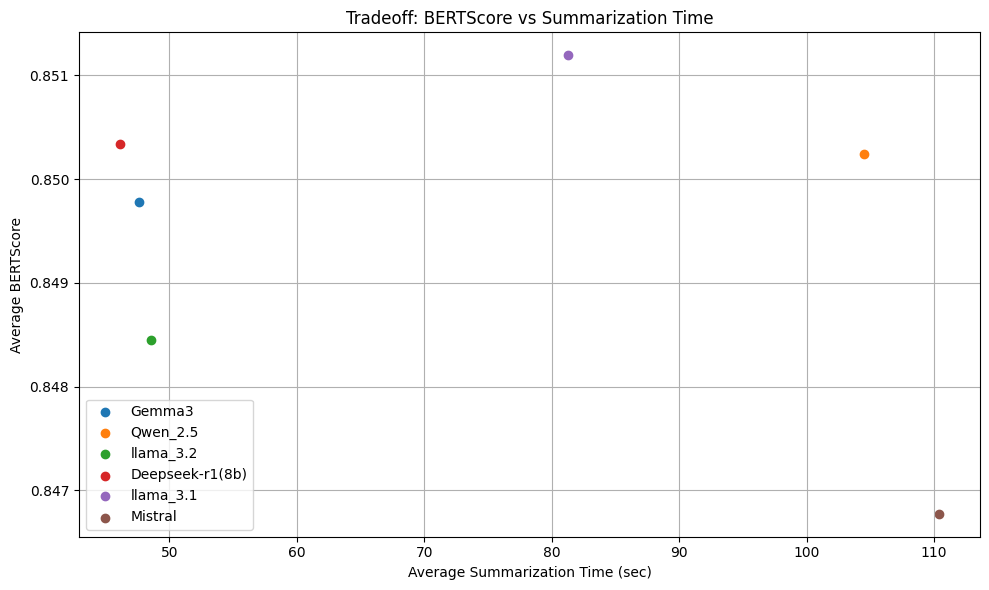

In [128]:
# Plot: Time vs ROUGE_avg per model (scatter)
plt.figure(figsize=(10, 6))
for model in df_all["Model"].unique():
    model_df = df_all[df_all["Model"] == model]
    plt.scatter(model_df["Summarization Time (sec)"].mean(), model_df["BERTScore"].mean(), label=model)

plt.xlabel("Average Summarization Time (sec)")
plt.ylabel("Average BERTScore")
plt.title("Tradeoff: BERTScore vs Summarization Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [130]:
avg_efficiency = df_all.groupby("Model")["Efficiency Score"].mean().sort_values(ascending=False)
avg_efficiency

Model
Gemma3             6.514469
Deepseek-r1(8b)    6.479263
llama_3.2          6.440136
llama_3.1          3.893066
Qwen_2.5           2.949029
Mistral            2.841899
Name: Efficiency Score, dtype: float64

### Annova

In [133]:
# ✅ Metrics to compare
metrics_to_test = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore", "Summarization Time (sec)","Word Count"]

# ✅ Normalize model names
df_all["Model"] = df_all["Model"].astype(str).str.strip().str.lower()

# ✅ Ensure numeric values
for metric in metrics_to_test:
    df_all[metric] = pd.to_numeric(df_all[metric], errors="coerce")

In [135]:
# ✅ Run ANOVA for each metric
anova_results = {}
for metric in metrics_to_test:
    groups = []
    for model in df_all["Model"].unique():
        values = df_all[df_all["Model"] == model][metric].dropna().values
        if len(values) > 0:
            groups.append(values)
    
    if len(groups) >= 2:
        stat, p_value = f_oneway(*groups)
        anova_results[metric] = round(p_value, 4)
    else:
        anova_results[metric] = "Insufficient data"

In [137]:
# ✅ Display as DataFrame
anova_df = pd.DataFrame.from_dict(anova_results, orient="index", columns=["ANOVA p-value"])
anova_df.index.name = "Metric"
print("\n📊 ANOVA Results:")
print(anova_df)



📊 ANOVA Results:
                          ANOVA p-value
Metric                                 
ROUGE-1                          0.8796
ROUGE-2                          0.9950
ROUGE-L                          0.9836
BERTScore                        0.9732
Summarization Time (sec)         0.0000
Word Count                       0.5492


In [139]:
# Prepare final ranking summary
final_summary = avg_stats.copy()
final_summary["Efficiency Score"] = avg_efficiency
final_summary = final_summary.sort_values("Efficiency Score", ascending=False)


In [141]:
final_summary

ROUGE-1   ROUGE-2   ROUGE-L  BERTScore  \
Model                                                      
Gemma3           0.412703  0.151570  0.204625   0.849782   
Deepseek-r1(8b)  0.403311  0.151670  0.200707   0.850337   
llama_3.2        0.405320  0.151487  0.201155   0.848448   
llama_3.1        0.388240  0.145013  0.197427   0.851195   
Qwen_2.5         0.408857  0.148968  0.198049   0.850242   
Mistral          0.408655  0.153634  0.203409   0.846775   

                 Summarization Time (sec)  Word Count  Efficiency Score  
Model                                                                    
Gemma3                          47.632667  366.400000          6.514469  
Deepseek-r1(8b)                 46.121333  352.533333          6.479263  
llama_3.2                       48.583333  371.266667          6.440136  
llama_3.1                       81.265333  330.066667          3.893066  
Qwen_2.5                       104.542667  362.533333          2.949029  
Mistral                        110.395333  370.066667          2.841899

### t-test

In [144]:


# Define top 3 models (make sure names match your df_all exactly)
top_models = ["gemma3", "deepseek-r1(8b)", "llama_3.2"]

# Extract summarization time data for each model
time_data = {
    model: df_all[df_all["Model"] == model]["Summarization Time (sec)"].dropna().values
    for model in top_models
}

time_data

{'gemma3': array([48.52, 41.58, 50.57, 46.09, 43.78, 52.03, 41.3 , 52.39, 44.44,
        57.9 , 54.51, 39.51, 47.85, 45.56, 48.46]),
 'deepseek-r1(8b)': array([48.99, 41.68, 45.87, 44.95, 34.13, 46.15, 43.3 , 38.9 , 45.89,
        45.09, 57.76, 43.08, 63.1 , 48.97, 43.96]),
 'llama_3.2': array([50.17, 53.63, 50.34, 36.7 , 36.57, 45.17, 40.3 , 62.51, 52.95,
        66.07, 53.24, 49.73, 44.04, 41.85, 45.48])}

In [146]:
print(df_all["Model"].unique())

['gemma3' 'qwen_2.5' 'llama_3.2' 'deepseek-r1(8b)' 'llama_3.1' 'mistral']


In [148]:
# Perform pairwise t-tests
ttest_results = {}
pairs = [("gemma3", "deepseek-r1(8b)"), ("gemma3", "llama_3.2"), ("deepseek-r1(8b)", "llama_3.2")]

for model_a, model_b in pairs:
    t_stat, p_value = ttest_ind(time_data[model_a], time_data[model_b], equal_var=False)
    ttest_results[f"{model_a} vs {model_b}"] = {
        "t-statistic": round(t_stat, 4),
        "p-value": round(p_value, 4)
    }

In [150]:
# Display results
ttest_df = pd.DataFrame.from_dict(ttest_results, orient="index")
ttest_df.index.name = "Model Pair"
print("\n📊 Pairwise T-Tests for Summarization Time:")
print(ttest_df)


📊 Pairwise T-Tests for Summarization Time:
                              t-statistic  p-value
Model Pair                                        
gemma3 vs deepseek-r1(8b)          0.6729   0.5070
gemma3 vs llama_3.2               -0.3690   0.7154
deepseek-r1(8b) vs llama_3.2      -0.8667   0.3937


In [18]:
pdf_path = "Downloads/sample/paper1.pdf"

In [242]:
a,b=extract_structured_text_from_pdf(pdf_path)

In [244]:
c=extract_text_from_pdf(pdf_path)

# Demonstration of all Preprocessing steps

In [12]:
def generate_file_hash(filepath):
    """
    Generates a SHA-256 hash for the file at the given path.
    This helps uniquely identify and detect duplicate files.
    """
    with open(filepath, "rb") as f:
        file_contents = f.read()
    return hashlib.sha256(file_contents).hexdigest()

In [20]:
# 2) Generate a file hash to detect duplicates (not shown in detail here).
file_hash = generate_file_hash(pdf_path)
print(f"File Hash: {file_hash}")

File Hash: c25c5ed38c1d951a240b372c337188ff024958d9249cea5361ee64c2fae2862b


In [22]:
# Define the folder where your PDF files are stored
pdf_folder = "Downloads/Research Papers 2"  # 🔁 Update with your actual path
# Loop through all PDF files in the folder
for filename in sorted(os.listdir(pdf_folder)):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(pdf_folder, filename)

        # Generate file hash
        file_hash = generate_file_hash(pdf_path)

        # Print the result
        print(f"{filename} ➜ Hash: {file_hash}")

paper1.pdf ➜ Hash: c25c5ed38c1d951a240b372c337188ff024958d9249cea5361ee64c2fae2862b
paper10.pdf ➜ Hash: 376d9e8ce0bcbc0cbcdff9bbd081ec6425072a9affe9b49ffab42ec2232d40ac
paper11.pdf ➜ Hash: 511afd0f2f8c48b7bcfd72711efa130d1621a20114ad50bd8887893284f2fc6e
paper12.pdf ➜ Hash: 57f28047ebc78e38f16c617b67c24bd0d1b23ba1a82145f23067a7d5918f73fe
paper13.pdf ➜ Hash: e5ba7e2ae7de6c5e9cf9e252884a0790638baf116590ed001ba7db8c8796e6c0
paper14.pdf ➜ Hash: 396a0fadeb4cd40f5c8ccc36b73a0815f6cb4d7f6bfa53b6c48c1f9aba7c7e02
paper15.pdf ➜ Hash: 6eae057a9faf4f671c3101e0745ed704460c6d3dec77243dfd3a9f2d2ab68970
paper2.pdf ➜ Hash: ff5819e3a7b713c3bd3107b7de3d51fe0a347aa5d8444f0efdcf2345ef0a8b63
paper3.pdf ➜ Hash: 1e0651b6810ecba34a3dbc5b5b0209226f889004607c1f203540a48d64e5a93a
paper4.pdf ➜ Hash: f6d77381228b86d8609e7205129b39b1a7f7820db133b46b7dc0e4119846b69d
paper5.pdf ➜ Hash: bdfaa68d8984f0dc02beaca527b76f207d99b666d31d1da728ee0728182df697
paper6.pdf ➜ Hash: 5692a5514787a8c6727b4ff3b726a3385798bc68e12138d1d4a

In [49]:
def load_embedding_model(model_name="all-MiniLM-L6-v2"):
    """
    Loads a SentenceTransformer model. 
    In Streamlit, you'd cache this to avoid reloading, 
    but here we simply instantiate it each time.
    """
    return SentenceTransformer(model_name)

def generate_embeddings(text):
    """
    Converts the given text into a dense vector representation 
    using a SentenceTransformer model.
    """
    model = load_embedding_model()
    return model.encode(text, convert_to_numpy=True).astype('float32')


In [26]:
def get_faiss_index(index_path="faiss_index.index"):
    """
    Loads an existing FAISS index from disk if present, 
    or returns None if it doesn't exist.
    """
    if os.path.exists(index_path):
        return faiss.read_index(index_path)
    return None

def save_faiss_index(index, index_path="faiss_index.index"):
    """
    Saves the current FAISS index to disk, 
    preserving the learned vector structure.
    """
    faiss.write_index(index, index_path)

def load_knowledge_base(kb_path="knowledge_base.json"):
    """
    Loads the knowledge base (list of PDF texts) from JSON.
    """
    if os.path.exists(kb_path):
        with open(kb_path, "r") as f:
            return json.load(f)
    return []

def save_knowledge_base(knowledge_base, kb_path="knowledge_base.json"):
    """
    Saves the knowledge base to JSON on disk for reuse.
    """
    with open(kb_path, "w") as f:
        json.dump(knowledge_base, f)


In [28]:
def retrieve_relevant_info(query_embedding, index, knowledge_base, top_k=3):
    """
    Given a query embedding, performs a similarity search in the FAISS index 
    to find the top_k most relevant documents from the knowledge base.
    """
    if index is None or index.ntotal == 0:
        return ["No relevant documents found."]

    query_embedding = np.array([query_embedding]).astype('float32')
    distances, indices = index.search(query_embedding, top_k)

    retrieved_docs = []
    for i in indices[0]:
        if 0 <= i < len(knowledge_base):
            retrieved_docs.append(knowledge_base[i])

    return retrieved_docs if retrieved_docs else ["No relevant documents found."]

def augment_prompt_with_retrieved_info(text, relevant_docs, query=None):
    """
    Combines the user's text or query with the relevant docs 
    to provide context for the LLM.
    """
    retrieved_info = "\n\n".join(relevant_docs)
    if query:
        augmented_prompt = (
            f"Context Information:\n{retrieved_info}\n\n"
            f"User Question: {query}\n\nAnswer:"
        )
    else:
        augmented_prompt = (
            f"Original Text:\n{text}\n\n"
            f"Retrieved Information:\n{retrieved_info}\n\n"
            "Summary:"
        )
    return augmented_prompt

def call_ollama_api(prompt, text=None):
    """
    Sends a prompt to the local Ollama API for summarization or Q&A.
    Adjust the URL or model name as needed.
    """
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": "deepseek-r1:7b",
        "prompt": f"{prompt}: {text}" if text else prompt,
        "stream": False
    }
    try:
        response = requests.post(url, json=payload, timeout=3000)
        response.raise_for_status()
        return response.json().get("response", "No response generated.")
    except requests.exceptions.RequestException as e:
        return f"Ollama API Error: {str(e)}"


In [30]:
# 4) Load or initialize the knowledge base and index.
knowledge_base = load_knowledge_base()
index = get_faiss_index()

# If no FAISS index file is found, we create a blank one with the correct dimension (MiniLM = 384).
if index is None:
    index = faiss.IndexFlatL2(384) 

In [32]:
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import numpy as np

# 1. Choose the same model name for both tokenization and embeddings
model_name = "sentence-transformers/all-MiniLM-L6-v2"

# 2. Load the Hugging Face tokenizer for the chosen model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. Define the text we want to process
text = "This is an example sentence to illustrate tokenization and vectorization"

# 4. Tokenize the text
encoded = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    return_tensors='pt',         # Return as PyTorch tensors
    return_attention_mask=False  # We only want to see token IDs here
)

token_ids = encoded["input_ids"][0]
tokens = [tokenizer.convert_ids_to_tokens([tid])[0] for tid in token_ids]

# 5. Print the token IDs and token strings
print("Original text:")
print(text)
print("\nStep 1: Tokenization:")
print("\nToken IDs:")
print(token_ids.tolist())
print("\nTokens:")
print(tokens)

# 6. Load the SentenceTransformer model and generate the embedding
model = SentenceTransformer(model_name)
embedding = model.encode(text, convert_to_numpy=True).astype('float32')

# 7. Display a sample of the embedding
print("\nStep 2: Embeddings:")
print("\nEmbedding shape:", embedding.shape)
print("Sample embedding values (first 20 dimensions):")
print(embedding[:20])


Original text:
This is an example sentence to illustrate tokenization and vectorization

Step 1: Tokenization:

Token IDs:
[101, 2023, 2003, 2019, 2742, 6251, 2000, 19141, 19204, 3989, 1998, 9207, 3989, 102]

Tokens:
['[CLS]', 'this', 'is', 'an', 'example', 'sentence', 'to', 'illustrate', 'token', '##ization', 'and', 'vector', '##ization', '[SEP]']


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Step 2: Embeddings:

Embedding shape: (384,)
Sample embedding values (first 20 dimensions):
[ 0.02853777  0.08226844  0.03734801  0.0331188   0.04716726  0.00316423
  0.08714339  0.02005985  0.0131845   0.00073176  0.05827313 -0.00201833
  0.04761961  0.00513821  0.01119517  0.02200647 -0.02385613  0.08998881
 -0.08269478 -0.02824724]


In [34]:
# 5) Load the SentenceTransformer model and generate embeddings for the extracted text.
model = load_embedding_model()
pdf_embedding = generate_embeddings(a, model)

In [35]:
pdf_embedding

array([ 1.2942127e-02, -2.9574158e-02,  2.0784514e-03,  2.1962170e-02,
        4.6819538e-02,  5.4006469e-02,  1.2066458e-02, -1.7967729e-02,
       -3.5641313e-02,  1.0418777e-02,  1.4468281e-02, -5.9304349e-02,
       -5.8022283e-02,  3.7088018e-02,  1.5801530e-02,  2.9645547e-02,
        3.6111549e-02, -3.7852410e-02, -2.7901996e-02,  3.5929080e-02,
        3.3020258e-02,  1.1604457e-02,  2.9133193e-02, -4.6846319e-02,
        5.1441938e-03,  7.2873287e-02,  2.4466285e-02, -1.3078640e-01,
       -3.6611557e-02,  3.7866596e-02,  1.0726043e-01, -8.8797897e-02,
        6.1946578e-02,  8.2105808e-02, -4.6931440e-03,  8.5470431e-02,
       -1.7041376e-02, -3.5226051e-02,  1.3745857e-02, -5.3495977e-02,
        5.8947089e-03,  1.3532125e-02, -6.9104873e-02, -5.3541832e-02,
       -1.0164707e-02, -3.1075854e-02,  2.7571866e-02, -1.6950408e-01,
       -3.5941035e-02, -5.5799272e-02,  1.4965491e-02,  2.5868984e-02,
        7.1875520e-02,  1.5442409e-03, -1.5277446e-02,  6.1949793e-02,
      

In [252]:
# 6) Append the text and its corresponding vector to knowledge base + index.
knowledge_base.append(a)
index.add(np.array([pdf_embedding]))
save_knowledge_base(knowledge_base)
save_faiss_index(index)

print(f"FAISS index now has {index.ntotal} entries.\n")

FAISS index now has 3 entries.



In [268]:
# Suppose we have three short text entries to store in our knowledge base.
# You could replace these with actual text from your PDF extraction phase.
knowledge_base = [
    "Deep learning is a subfield of machine learning concerned with algorithms inspired by the structure and function of the brain.",
    "FAISS is a library for efficient similarity search and clustering of dense vectors.",
    "Sentence embeddings map entire sentences to a vector space in which semantically similar sentences are close."
]

# Generate embeddings for each piece of text
embeddings = model.encode(knowledge_base, convert_to_numpy=True).astype('float32')

# Check shapes
print("Embeddings array shape:", embeddings.shape)


Embeddings array shape: (3, 384)


In [270]:
# Create an IndexFlatL2 for brute-force L2 distance search with dimension 384
dimension = 384
index = faiss.IndexFlatL2(dimension)

# Add embeddings to the index
index.add(embeddings)

print("Number of vectors in index:", index.ntotal)


Number of vectors in index: 3


In [272]:
def retrieve_relevant_docs(query: str, knowledge_base, index, top_k=2):
    # Generate an embedding for the user query
    query_embedding = model.encode([query], convert_to_numpy=True).astype('float32')
    
    # Search for top_k nearest neighbors
    distances, indices = index.search(query_embedding, top_k)
    
    # Collect matched documents
    retrieved = []
    for idx in indices[0]:
        retrieved.append(knowledge_base[idx])
    return retrieved, distances[0]


In [274]:
user_query = "What do I need for similarity search in machine learning?"
retrieved_docs, dists = retrieve_relevant_docs(user_query, knowledge_base, index, top_k=2)

print(f"User Query: {user_query}\n")
for i, (doc, dist) in enumerate(zip(retrieved_docs, dists)):
    print(f"Rank {i+1} (Distance: {dist:.4f})")
    print(f"Document: {doc}\n")


User Query: What do I need for similarity search in machine learning?

Rank 1 (Distance: 0.8856)
Document: FAISS is a library for efficient similarity search and clustering of dense vectors.

Rank 2 (Distance: 1.3834)
Document: Sentence embeddings map entire sentences to a vector space in which semantically similar sentences are close.



In [65]:
# 7) Example query
user_query = "What is the main topic of this document?"
query_embedding = generate_embeddings(user_query, model)
top_docs = retrieve_relevant_info(query_embedding, index, knowledge_base, top_k=3)
print("Top retrieved documents for the query:")
for doc in top_docs:
    print("-------------")
    print(doc[:200], "...\n")

Top retrieved documents for the query:
-------------
Frequency modulation entrains slow neural oscillations
and optimizes human listening behavior
MollyJ.Henry1andJonasObleser1
MaxPlanckResearchGroupAuditoryCognition,MaxPlanckInstituteforHumanCognitivea ...

-------------
Preamble: Deep Residual Learning for Image Recognition Kaiming He Xiangyu Zhang Shaoqing Ren Jian Sun Microsoft Research { kahe, v-xiangz, v-shren, jiansun } @microsoft.com

Title: Deep Residual Learn ...



In [69]:
# 8) Construct a final prompt and pass it to the local LLM (Ollama).
aug_prompt = augment_prompt_with_retrieved_info(a, top_docs, query=user_query)
response = call_ollama_api(user_query, aug_prompt)
print("LLM Response:\n", response)

LLM Response:
 <think>
Alright, so the user asked, "What is the main topic of this document?" Looking at the provided text, it's a detailed description of experiments and results related to image classification, detection, and localization using neural networks like ResNet-101. The document talks about methods, results on datasets like ILSVRC 2014 and 2015, comparisons with other models, and mentions winning first place in certain tasks.

I need to identify the main topic. It's clear that the focus is on computer vision techniques using deep learning models for image understanding tasks. The key areas are classification, detection, and localization. Even though these are subfields of computer vision, they all fall under a broader umbrella of image understanding or perhaps even specifically neural network architectures applied to vision.

So, putting it together, the main topic is about applying deep learning techniques, particularly using ResNet-101 on tasks like classification, detect

## Q and A analysis

In [51]:
def chunk_text(text: str, chunk_size: int = 500, overlap: int = 50) -> list[str]:
    """Split text into overlapping chunks of ≤chunk_size words."""
    words, chunks = text.split(), []
    step = chunk_size - overlap
    for i in range(0, len(words), step):
        chunks.append(" ".join(words[i : i + chunk_size]))
    return chunks

def rag_process_pdf(pdf_path: str, question: str | None = None) -> str:
    """
    1) Use extract_structured_text_from_pdf to get formatted_text.
    2) Hash the file path; if unseen, chunk+embed and add to FAISS+KB.
    3) If no question: return a summary. If question: return a RAG answer.
    """
    # — 1) file‐hash to avoid re‐indexing
    file_hash = generate_file_hash(pdf_path)   # <-- pass path, not file object

    # — 2) load or create index + knowledge base
    index = get_faiss_index()
    kb    = load_knowledge_base()

    # — 3) ingest this PDF if it's not in KB yet
    if not any(entry.get("file_hash") == file_hash for entry in kb):
        # reuse your extractor
        formatted_text, _ = extract_structured_text_from_pdf(pdf_path)

        # chunk & embed
        chunks = chunk_text(formatted_text)
        embs   = [generate_embeddings(c) for c in chunks]

        # init FAISS if needed
        if index is None:
            dim = embs[0].shape[0]
            index = faiss.IndexFlatL2(dim)

        # add each chunk to index + KB
        for chunk, emb in zip(chunks, embs):
            index.add(np.array([emb]))
            kb.append({"file_hash": file_hash, "text": chunk})

        # persist
        save_faiss_index(index)
        save_knowledge_base(kb)

    # — 4) build prompt
    if question is None:
        # summarization prompt
        formatted_text, _ = extract_structured_text_from_pdf(pdf_path)
        docs   = [e["text"] for e in kb if e["file_hash"] == file_hash]
        prompt = augment_prompt_with_retrieved_info(formatted_text, docs)
    else:
        # QA prompt
        q_emb     = generate_embeddings(question)
        docs      = [e["text"] for e in kb if e["file_hash"] == file_hash]
        relevant  = retrieve_relevant_info(q_emb, index, docs)
        prompt    = augment_prompt_with_retrieved_info(None, relevant, query=question)

    # — 5) ask your LLM
    return call_ollama_api(prompt)


In [53]:
if os.path.exists("knowledge_base.json"):
    os.remove("knowledge_base.json")
# First get a summary
summary = rag_process_pdf("Downloads/Research Papers 2/paper1.pdf")
print("Summary:", summary)

# Then ask a follow‑up
answer = rag_process_pdf(
    "Downloads/Research Papers 2/paper1.pdf",
    question="What feature selection method did they use?"
)
print("A:", answer)


Summary: <think>
Okay, so I have this user query where they provided a bunch of text snippets from various scientific papers related to autism spectrum disorder (ASD). They also included some detailed instructions on how to process the content into a summary. The user is asking for a summary based on their original text.

First, I need to understand what exactly the user wants. From the context, it looks like they're using these specific terms: "original Text", "Summary", and "Key findings". They also provided an example response where each section of the original text was labeled with these tags and then a concise summary was made from each part.

Looking at their original text, there are multiple sections discussing various aspects of ASD. For instance, some parts talk about ERP responses to faces, inhibitory control differences between ADHD and typical adults, neurophysiological evidence related to optic flow perception in ASD, molecular imaging studies using PET and SPECT, and more

In [86]:
def write_csv(paper_label, qas, output_folder):
    """Write one CSV per paper with headers 'Question' and 'Answer'."""
    os.makedirs(output_folder, exist_ok=True)
    csv_path = os.path.join(output_folder, f"{paper_label}.csv")
    print(f"[INFO] Writing CSV for {paper_label} at {csv_path}")
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Question", "Answer"])
        for idx, (q, a) in enumerate(qas, start=1):
            writer.writerow([q, a])
            print(f"[DEBUG] Row {idx}: Q='{q[:30]}...' A='{a[:30]}...'")
    print(f"[INFO] Finished writing {csv_path}")

def generate_csvs_from_docx(docx_path, output_folder="csv_output"):
    """
    Parses a .docx where:
      - Sections start with 'Paper N:'
      - Questions are wrapped in <Question>...</Question>
      - Answers are wrapped in <Answer>...</Answer>
    and writes one CSV per paper with two columns.
    """
    print(f"[INFO] Loading document {docx_path}")
    doc = Document(docx_path)
    paper_label = None
    qas = []

    paper_re = re.compile(r"^Paper\s*(\d+):", re.IGNORECASE)

    for para in doc.paragraphs:
        text = para.text.strip()
        if not text:
            continue

        # New paper section
        m = paper_re.match(text)
        if m:
            # flush previous
            if paper_label and qas:
                write_csv(paper_label, qas, output_folder)
            paper_label = f"Paper{m.group(1)}"
            print(f"[INFO] Starting section {paper_label}")
            qas = []
            continue

        # extract all <Question> and <Answer> pairs in this paragraph
        questions = re.findall(r"<Question>(.*?)</Question>", text)
        answers   = re.findall(r"<Answer>(.*?)</Answer>", text)

        if questions and answers:
            count = min(len(questions), len(answers))
            print(f"[DEBUG] Found {count} Q&A pairs in paragraph.")
            for i in range(count):
                q, a = questions[i].strip(), answers[i].strip()
                qas.append((q, a))
        else:
            if "<Question>" in text or "<Answer>" in text:
                print(f"[WARN] Mismatched tags or missing pairs in text: {text}")

    # flush last paper
    if paper_label and qas:
        write_csv(paper_label, qas, output_folder)
    print("[INFO] All papers processed.")

In [88]:
# Example usage:
if __name__ == "__main__":
    docx_path = "Downloads/15Qns_of_each_paper.docx"
    generate_csvs_from_docx(docx_path, output_folder="Downloads/sample/QnA")

[INFO] Loading document Downloads/15Qns_of_each_paper.docx
[INFO] Starting section Paper1
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[DEBUG] Found 1 Q&A pairs in paragraph.
[INFO] Writing CSV for Paper1 at Downloads/sample/QnA/Paper1.csv
[DEBUG] Row 1: Q='Who are the author for this pa...' A='Alex Lau-Zhu⁎, Anne Fritz, Grá...'
[DEBUG] Row 2: Q='What neurodevelopmental condit...' A='ADHD and ASD in young adulthoo...'
[DEBUG] Row 3: Q='What 

In [92]:
# --- CONFIG ---
PDF_FOLDER = "Downloads/Research Papers 2"     # your folder with paper1.pdf … paper15.pdf
CSV_FOLDER = "Downloads/sample/QnA"             # where Paper1.csv … Paper15.csv live
MODEL_NAME = "llama 3.2"                # used for header naming

# bring in your rag_process_pdf function
# from your_module import rag_process_pdf
# name of the new column
response_col = f"{MODEL_NAME}_responses"

for paper_id in range(1, 16):
    pdf_path = os.path.join(PDF_FOLDER, f"paper{paper_id}.pdf")
    csv_path = os.path.join(CSV_FOLDER, f"Paper{paper_id}.csv")

    print(f"\n=== PAPER {paper_id}: priming RAG index & summary… ===")
    _ = rag_process_pdf(pdf_path)  # build index & summary once

    print(f"Opening CSV {csv_path} for Q→model answers…")
    # 1) read existing rows
    with open(csv_path, newline="", encoding="utf-8") as f:
        reader     = csv.DictReader(f)
        original_fields = reader.fieldnames or []
        if response_col in original_fields:
            print(f"  → Column '{response_col}' already exists, skipping.")
            continue
        rows       = list(reader)

    # 2) ask model each question and append to rows
    print(f"  → Asking model for {len(rows)} questions…")
    for idx, row in enumerate(rows, start=1):
        q = row["Question"]
        prompt = f"Answer the following question in one sentence: {q}"
        print(f"    [{paper_id}.{idx}] {prompt}")
        ans = rag_process_pdf(pdf_path, question=prompt)
        row[response_col] = ans
        print(f"       → {ans}")

    # 3) write back CSV with new column appended
    new_fields = original_fields + [response_col]
    print(f"  → Writing back CSV with new column '{response_col}'…")
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=new_fields)
        writer.writeheader()
        writer.writerows(rows)

    print(f"✅ Updated {csv_path}")

print("\nAll papers processed. Each CSV now has a third column with model responses.") 


=== PAPER 1: priming RAG index & summary… ===
Opening CSV Downloads/sample/QnA/Paper1.csv for Q→model answers…
  → Asking model for 16 questions…
    [1.1] Answer the following question in one sentence: Who are the author for this paper?
       → <think>
Alright, so I need to figure out who the authors of a particular paper are. But wait, there's no context given here—no title or abstract provided. That makes it tricky because without knowing what paper we're talking about, how can I identify its authors? 

Hmm, maybe sometimes papers have author names embedded in their titles or abstracts, but since that information isn't available, I'm kind of stuck. Without any reference points, it's hard to pinpoint the correct authors. I wonder if there's a way to default to an assumption here. Maybe assuming a common author like David A. Smith could be a start, but I don't have any real basis for that.

I should also consider whether the user is referring to a specific paper they're working on o

KeyboardInterrupt: 

In [35]:
# Step 6: Generate summary using Ollama API
def summarize_text(prompt, model="deepseek-r1:7b"):
    """
    Sends the augmented prompt to Ollama API for summarization.
    """
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": model,
        "prompt": prompt,
        "stream": False
    }
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        response_json = response.json()
        summary = response_json.get("response", "No response generated.")
    else:
        summary = f"Error: {response.status_code}, {response.text}"
    return summary



In [37]:
# Main pipeline
if __name__ == "__main__":
    # Step 1: Extract text from PDF
    pdf_file_path = "Downloads/Data Mining_Final Report.pdf"  # Change this to your PDF file path
    print("Extracting text from PDF...")
    extracted_text = extract_text_from_pdf(pdf_file_path)

    # Step 2: Generate embeddings for the extracted text
    print("Generating embeddings...")
    embeddings = generate_embeddings(extracted_text)

    # Step 3: Set up a knowledge base (FAISS index)
    print("Creating FAISS index...")
    knowledge_base = [extracted_text]  # For simplicity, using the extracted text as the knowledge base
    index = create_faiss_index(np.array([embeddings]))

    # Step 4: Retrieve relevant information
    print("Retrieving relevant information...")
    query_embedding = embeddings  # Use the same embeddings as the query
    relevant_docs = retrieve_relevant_info(query_embedding, index, knowledge_base, top_k=3)

    # Step 5: Augment the prompt with retrieved information
    print("Augmenting prompt with retrieved information...")
    augmented_prompt = augment_prompt_with_retrieved_info(extracted_text, relevant_docs)

    # Step 6: Generate summary
    print("Generating summary...")
    summary = summarize_text(augmented_prompt)

    print("\n--- Summary of the Research Paper ---\n")
    print(summary)

Extracting text from PDF...
Generating embeddings...
Creating FAISS index...
Retrieving relevant information...
Augmenting prompt with retrieved information...
Generating summary...

--- Summary of the Research Paper ---

<think>
Okay, so I'm trying to summarize this project about developing a web application to detect fake job listings using machine learning. Let me go through the document step by step.

First, they mention that the original text was cut off after "7 CONCLUSION AND FUTURE SCOPE", but in my case, it's provided up to reference 13. So I have enough information without needing to refer to the cut-off part. 

Starting from the beginning: The project is about creating a web app that identifies fake jobs by analyzing job posts with machine learning techniques. They used several algorithms like Random Forest and XGBoost. 

Looking at the results section, they mention experiments were conducted on imbalanced datasets, using metrics like accuracy, precision, recall, F1-score, A